# 0. Imports

In [ ]:
%pip install yfinance

In [1]:
import yfinance as yf

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, GRU, SimpleRNN, Dense, Dropout

import itertools
from tqdm import tqdm
import multiprocessing
from functools import partial


# 1. Load Data

In [2]:
# Get Google's stock price history and put it into a pandas DataFrame
google_ticker = yf.Ticker("GOOGL")
stock_data = google_ticker.history(period="max").drop(columns=["Dividends", "Stock Splits"])

In [3]:
display(stock_data.head())
display(stock_data.shape)

,Open,High,Low,Close,Volume
Date,,,,,
2004-08-19 00:00:00-04:00,2.496321,2.597672,2.395469,2.504808,893181924
2004-08-20 00:00:00-04:00,2.521534,2.722987,2.508803,2.703765,456686856
2004-08-23 00:00:00-04:00,2.764676,2.832825,2.722238,2.730975,365122512
2004-08-24 00:00:00-04:00,2.776908,2.785895,2.585440,2.617892,304946748
2004-08-25 00:00:00-04:00,2.620139,2.696027,2.593179,2.646101,183772044


(5110, 5)

# 2. Visualize Data

In [4]:
display(stock_data.describe())
display(stock_data.info())

,Open,High,Low,Close,Volume
count,5110.000000,5110.000000,5110.000000,5110.000000,5.110000e+03
mean,47.312989,47.806555,46.824951,47.325104,1.158830e+08
std,45.347809,45.839247,44.882649,45.367004,1.471020e+08
min,2.476101,2.539757,2.395469,2.496571,9.312000e+06
25%,13.143630,13.254592,13.000154,13.141196,3.065700e+07
50%,27.911387,28.074982,27.663366,27.868742,5.774000e+07
75%,62.445749,63.114469,61.851970,62.558595,1.394824e+08
max,190.057808,191.495888,188.779491,190.926636,1.643023e+09


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5110 entries, 2004-08-19 00:00:00-04:00 to 2024-12-05 00:00:00-05:00
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    5110 non-null   float64
 1   High    5110 non-null   float64
 2   Low     5110 non-null   float64
 3   Close   5110 non-null   float64
 4   Volume  5110 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 239.5 KB


None

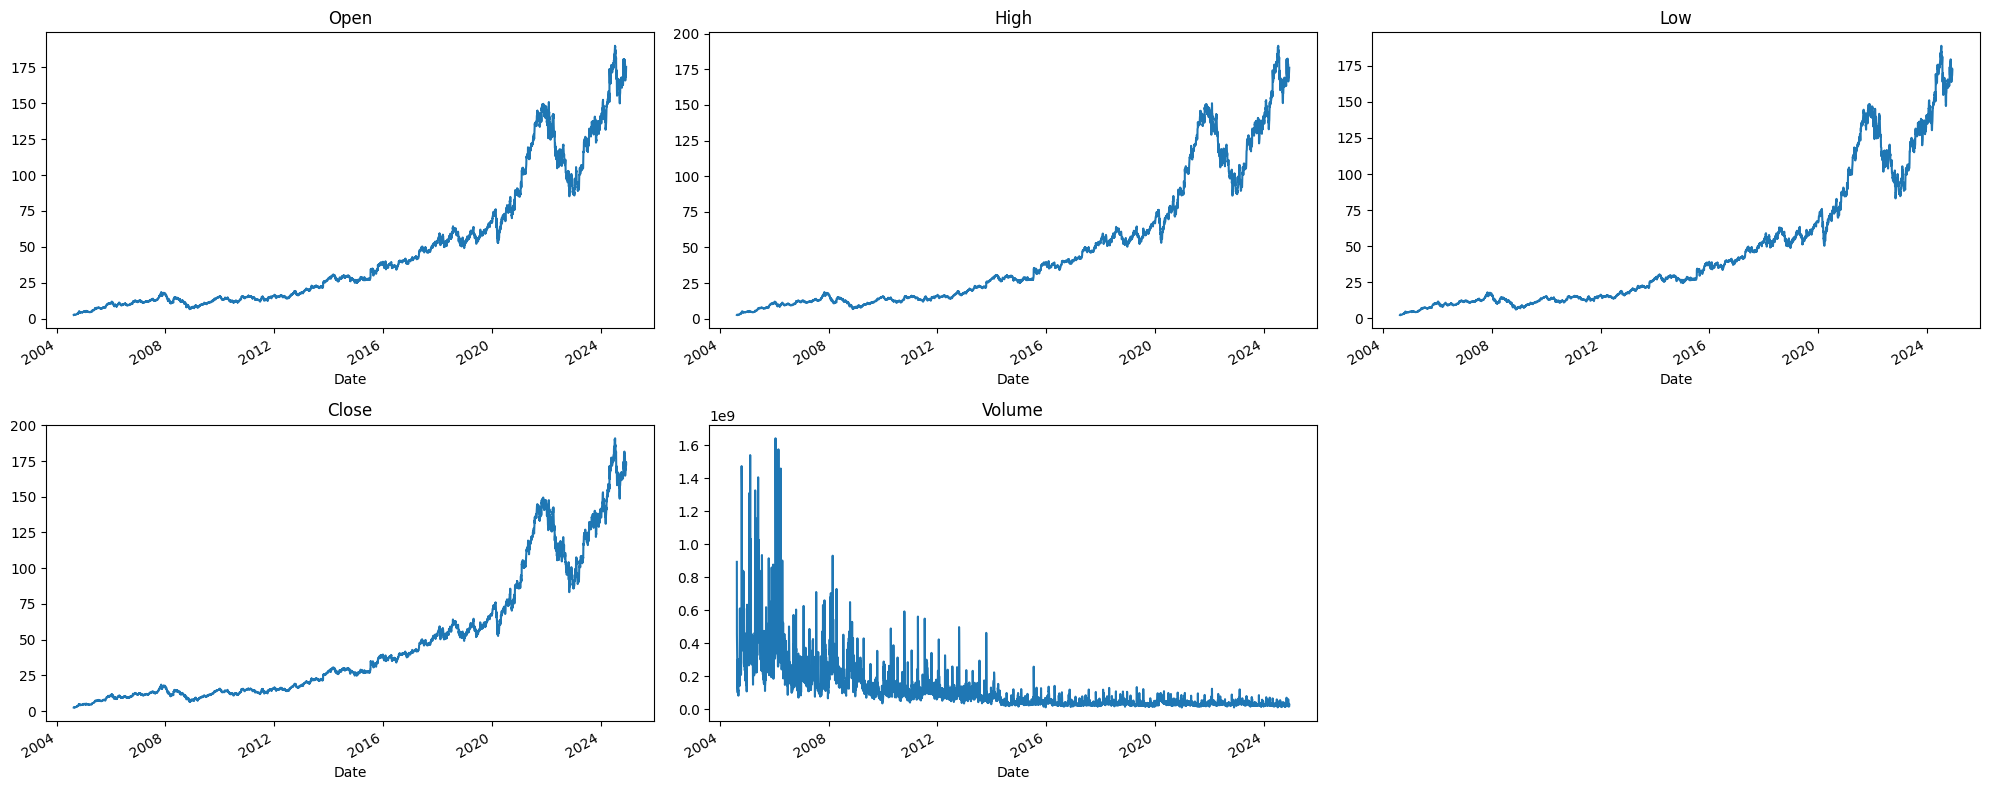

In [5]:
# plot all the columns in a 3x2 grid as line plots
plt.figure(figsize=(20, 8))
for i, column in enumerate(stock_data.columns):
    plt.subplot(2, 3, i+1)
    stock_data[column].plot()
    plt.title(column)
plt.tight_layout()
plt.show()


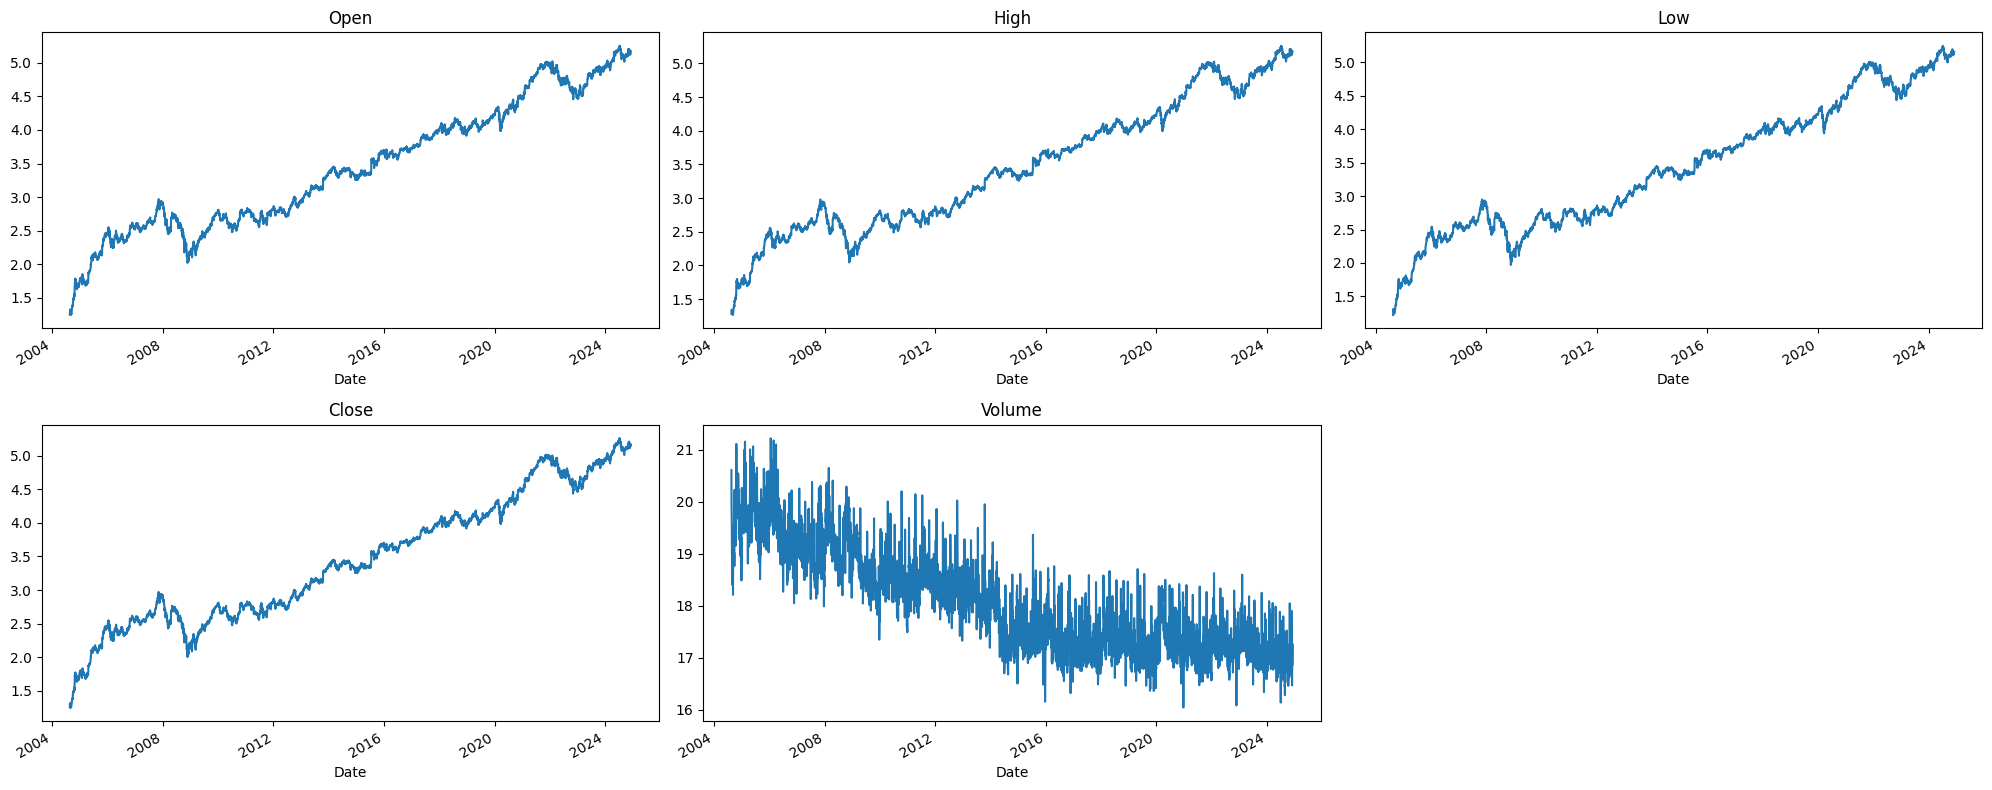

In [6]:
# plot all the columns in a 3x2 grid as line plots after normalizing the data using Log Normalization
plt.figure(figsize=(20, 8))
for i, column in enumerate(stock_data.columns):
    plt.subplot(2, 3, i+1)
    np.log1p(stock_data[column]).plot()
    plt.title(column)
plt.tight_layout()
plt.show()

In [7]:
# Create new column in the dataframe that contains the percentage change between the Open and Close columns
stock_data["Open-Close-1D"] =  (stock_data.Close - stock_data.Open)
# Create new column in the dataframe that contains the percentage change between the that day's Open and next day's Close columns
stock_data["Open-Close-2D"] = (stock_data.Close.shift(-1) - stock_data.Open)

# Create a DataFrame to store the descriptive statistics
stats_OC = pd.DataFrame({
    "Open-Close-1D": stock_data["Open-Close-1D"].describe(),
    "Open-Close-2D": stock_data["Open-Close-2D"].describe()
})

display(stats_OC)

,Open-Close-1D,Open-Close-2D
count,5110.000000,5109.000000
mean,0.012115,0.045951
std,0.908254,1.475311
min,-6.628591,-12.668626
25%,-0.178113,-0.264858
50%,0.001997,0.025933
75%,0.209465,0.363713
max,7.718383,20.569077


In [8]:
# Create a DataFrame to store the descriptive statistics
stats_OC_PN = pd.DataFrame({
    "Open-Close-1D Positive": stock_data["Open-Close-1D"].where(lambda x: x > 0).describe(),
    "Open-Close-1D Negative": stock_data["Open-Close-1D"].where(lambda x: x < 0).describe(),
    "Open-Close-2D Positive": stock_data["Open-Close-2D"].where(lambda x: x > 0).describe(),
    "Open-Close-2D Negative": stock_data["Open-Close-2D"].where(lambda x: x < 0).describe()
})

display(stats_OC_PN)

,Open-Close-1D Positive,Open-Close-1D Negative,Open-Close-2D Positive,Open-Close-2D Negative
count,2578.000000,2523.000000,2704.000000,2405.000000
mean,0.497009,-0.483307,0.780376,-0.779782
std,0.746712,0.784531,1.221150,1.288105
min,0.000251,-6.628591,0.000001,-12.668626
25%,0.080132,-0.488791,0.127591,-0.816975
50%,0.207214,-0.183045,0.331012,-0.295314
75%,0.560360,-0.072019,0.847411,-0.124067
max,7.718383,-0.000249,20.569077,-0.000249


In [9]:
stock_data.info()
stock_data.dropna(inplace=True)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5110 entries, 2004-08-19 00:00:00-04:00 to 2024-12-05 00:00:00-05:00
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Open           5110 non-null   float64
 1   High           5110 non-null   float64
 2   Low            5110 non-null   float64
 3   Close          5110 non-null   float64
 4   Volume         5110 non-null   int64  
 5   Open-Close-1D  5110 non-null   float64
 6   Open-Close-2D  5109 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 319.4 KB


Text(0.5, 1.0, 'Open-Close-2D')

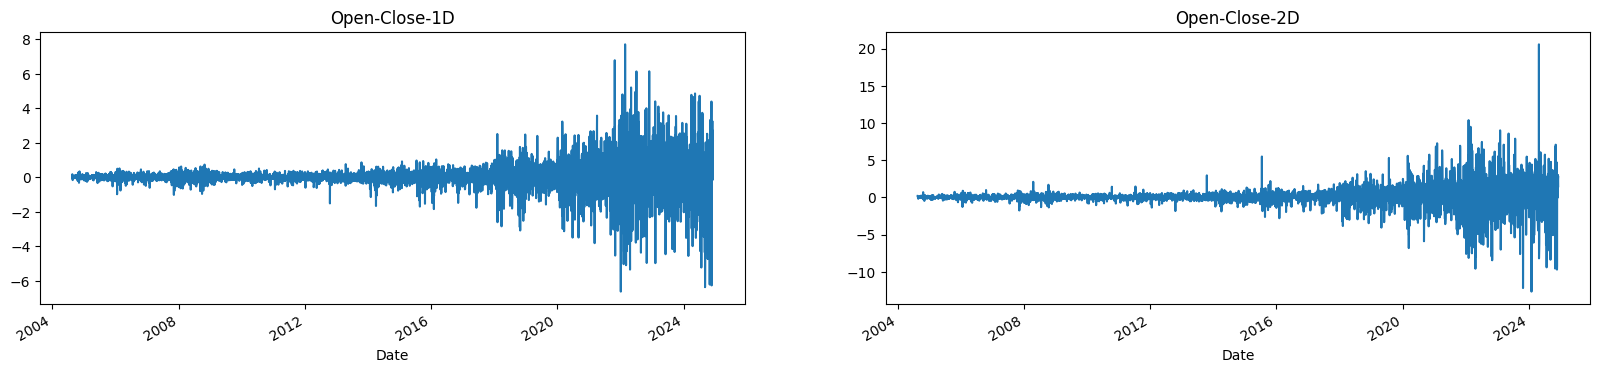

In [10]:
# Plot the Open-Close-1D and Open-Close-2D columns
plt.figure(figsize=(20, 4))
plt.subplot(1, 2, 1)
stock_data["Open-Close-1D"].plot()
plt.title("Open-Close-1D")
plt.subplot(1, 2, 2)
stock_data["Open-Close-2D"].plot()
plt.title("Open-Close-2D")

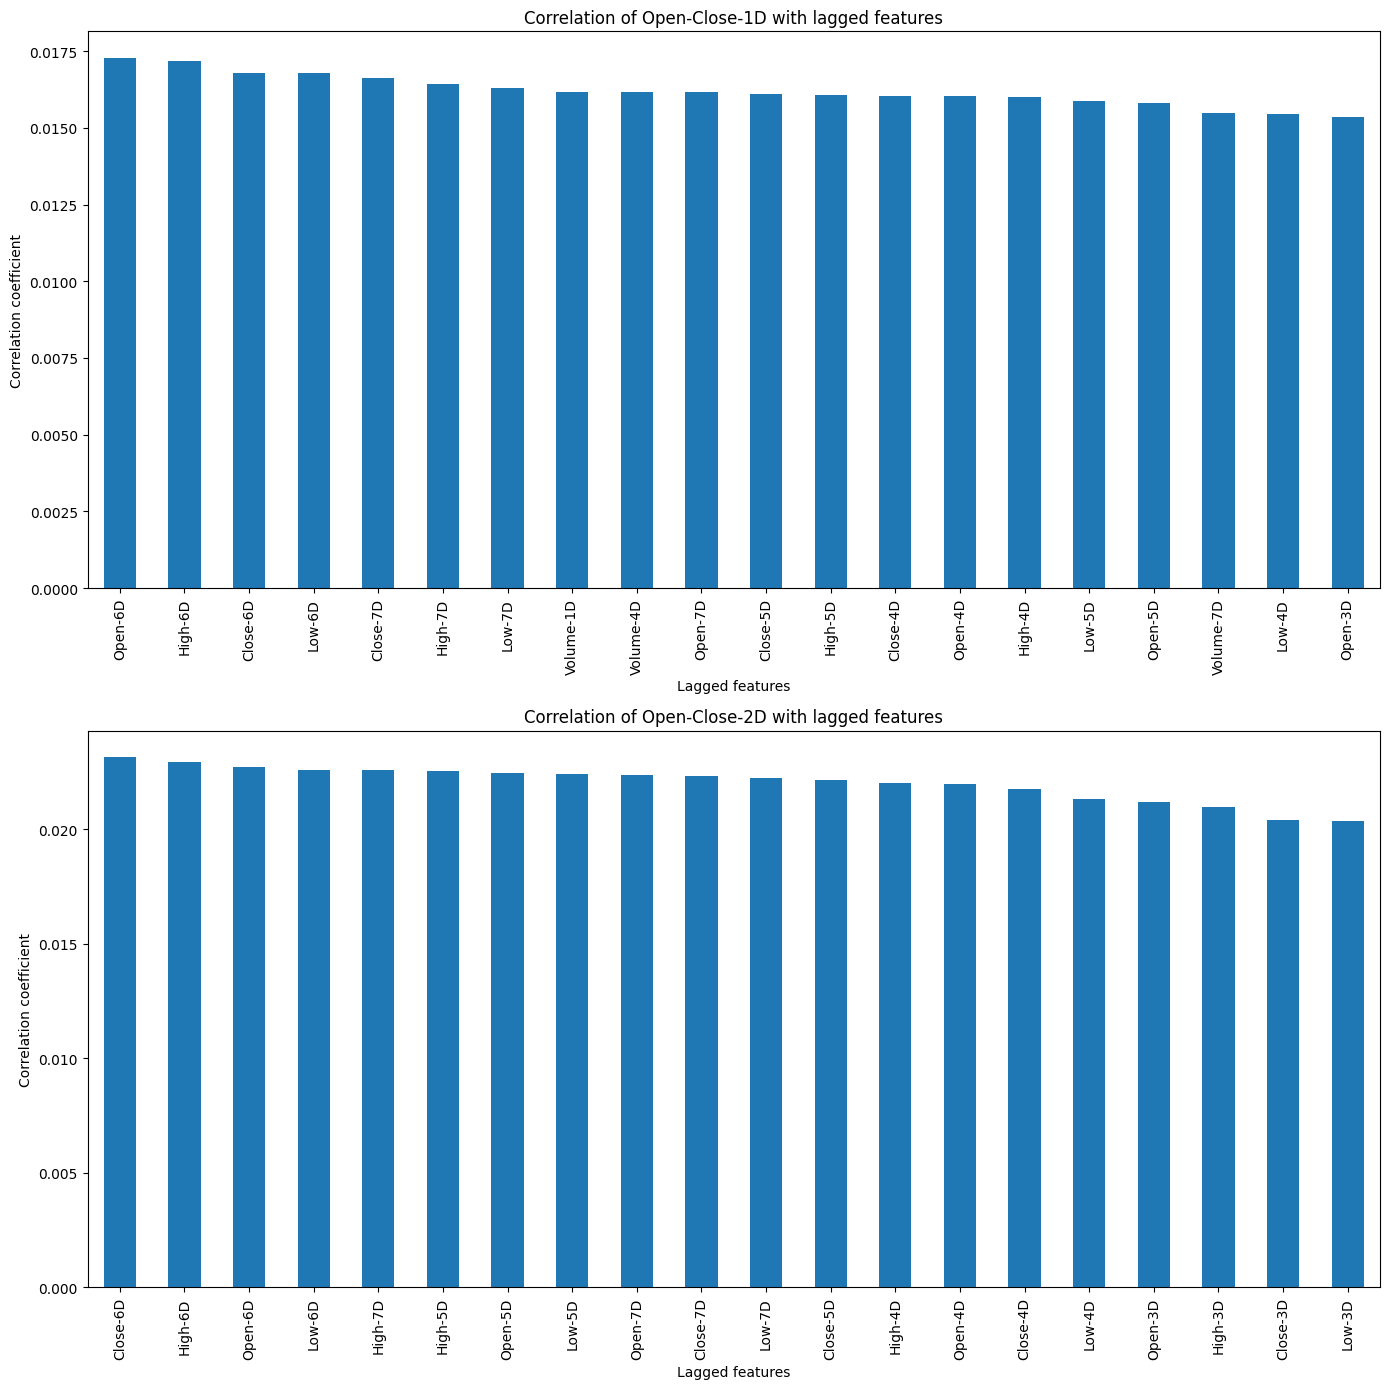

In [11]:
# Compare correlation between lagged rows of Open, Close, High, Low and Volume columns up to 7 days in the past with the Open-Close-1D and Open-Close-2D columns
corr_OC = stock_data[["Open", "Close", "High", "Low", "Volume", "Open-Close-1D", "Open-Close-2D"]].copy()
for i in range(1, 8):
    corr_OC[f"Open-{i}D"] = corr_OC.Open.shift(i)
    corr_OC[f"Close-{i}D"] = corr_OC.Close.shift(i)
    corr_OC[f"High-{i}D"] = corr_OC.High.shift(i)
    corr_OC[f"Low-{i}D"] = corr_OC.Low.shift(i)
    corr_OC[f"Volume-{i}D"] = corr_OC.Volume.shift(i)

# Show only the correlation between the Open-Close-1D and Open-Close-2D columns with the lagged rows of Open, Close, High, Low and Volume columns
corr_OC = corr_OC.corr()[["Open-Close-1D", "Open-Close-2D"]].drop(["Open-Close-1D", "Open-Close-2D", "Open", "Close", "High", "Low", "Volume"])

# Visualize the correlation in a bar chart for Open-Close-1D and Open-Close-2D in 2 subplots
plt.figure(figsize=(14, 14))

plt.subplot(2, 1, 1)
corr_OC["Open-Close-1D"].abs().sort_values(ascending=False)[:20].plot(kind='bar')
plt.title('Correlation of Open-Close-1D with lagged features')
plt.ylabel('Correlation coefficient')
plt.xlabel('Lagged features')

plt.subplot(2, 1, 2)
corr_OC["Open-Close-2D"].abs().sort_values(ascending=False)[:20].plot(kind='bar')
plt.title('Correlation of Open-Close-2D with lagged features')
plt.ylabel('Correlation coefficient')
plt.xlabel('Lagged features')

plt.tight_layout()
plt.show()


# 3. Data Preprocessing and Feature Engineering

In [12]:
# Prepare data for RNN using multiple features and flexible future prediction
def prepare_data(data, look_back=5, predict_days=3, feature_scaler=None, target_scaler=None):
    # Select relevant features
    features = ['Open', 'High', 'Low', 'Close', 'Volume']

    # Create feature and target datasets
    X, y = [], []

    # If no scalers are provided, create new ones
    if feature_scaler is None:
        feature_scaler = MinMaxScaler(feature_range=(0, 1))
        feature_scaler.fit(data[features])

    if target_scaler is None:
        target_scaler = MinMaxScaler(feature_range=(0, 1))
        target_scaler.fit(data[['Close']])

    # Scale features
    scaled_features = feature_scaler.transform(data[features])
    scaled_features_df = pd.DataFrame(scaled_features, columns=features)

    # Prepare sequences for prediction
    for i in range(len(scaled_features_df) - look_back - predict_days + 1):
        # Input: look_back days of features
        X.append(scaled_features_df.iloc[i:i+look_back, :].values)

        # Target: future Close prices for specified number of days
        future_closes = data['Close'].iloc[i+look_back:i+look_back+predict_days]
        scaled_future_closes = target_scaler.transform(future_closes.values.reshape(-1, 1))
        y.append(scaled_future_closes.flatten())

    return (np.array(X), np.array(y), feature_scaler, target_scaler)


# 4. Data Splitting

In [13]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='sklearn')


In [14]:
# Split the data based on the year
train_data = stock_data[stock_data.index.year < 2023]
val_data = stock_data[(stock_data.index.year == 2023)]
test_data = stock_data[stock_data.index.year == 2024]

look_back = 5
predict_days = 2

# Prepare data with a single scaler fitted on training data
# Fit scaler only on training data
_, _, feature_scaler, target_scaler = prepare_data(train_data, look_back, predict_days)

# Prepare data using the same scaler
X_train, y_train, _, _ = prepare_data(train_data, look_back, predict_days, feature_scaler, target_scaler)
X_val, y_val, _, _ = prepare_data(val_data, look_back, predict_days, feature_scaler, target_scaler)
X_test, y_test, _, _ = prepare_data(test_data, look_back, predict_days, feature_scaler, target_scaler)

display(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape)

(4619, 5, 5)

(4619, 2)

(244, 5, 5)

(244, 2)

(228, 5, 5)

(228, 2)

# 5. Model Selection

In [15]:
class ModelType:
    LSTM = "LSTM"
    GRU = "GRU"
    RNN = "RNN"

predict_days = 2
look_back = 5

In [16]:
# Build Recurrent model with configurable architecture
def build_model(look_back, num_features, model_config, type=ModelType.RNN):
    model = Sequential()

    switcher = {
        ModelType.LSTM: LSTM,
        ModelType.GRU: GRU,
        ModelType.RNN: SimpleRNN
    }
    layer = switcher[type]

    model.add(Input(shape=(look_back, num_features)))

    # Add Recurrent layers based on configuration
    for i, layer_config in enumerate(model_config['recurrent_layers']):
        # First layer needs input_shape
        if i == 0:
            model.add(layer(
                layer_config['units'],
                return_sequences=len(model_config['recurrent_layers']) > 1
            ))
        else:
            model.add(layer(
                layer_config['units'],
                return_sequences=(i < len(model_config['recurrent_layers']) - 1)
            ))

        # Add dropout if specified
        if layer_config.get('dropout', 0) > 0:
            model.add(Dropout(layer_config['dropout']))

    # Add dense layers
    for dense_layer in model_config.get('dense_layers', []):
        model.add(Dense(dense_layer['units'], activation=dense_layer.get('activation', 'relu')))

    # Final dense layer for output
    model.add(Dense(model_config.get('output_units', 1)))

    # Create optimizer with configurable learning rate
    optimizer = tf.keras.optimizers.Adam(learning_rate=model_config.get('learning_rate', 0.001))

    # Compile model
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

    return model


In [17]:
def fit_model(model, X_train, y_train, X_val, y_val, fit_config_baseline):
    # Build and train model

    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True
    )

    history = model.fit(
        X_train, y_train,
        epochs=fit_config_baseline['epochs'],
        batch_size=fit_config_baseline['batch_size'],
        validation_data=(X_val, y_val),
        callbacks=[early_stopping],
        verbose=1
    )

    return history, model

def evaluate_model(model, history, X_train, y_train, X_val, y_val, target_scaler, predict_days, model_type=ModelType.RNN):
    # Plot training history
    plt.figure(figsize=(10,10))

    plt.subplot(2, 1, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(history.history['mae'], label='Training MAE')
    plt.plot(history.history['val_mae'], label='Validation MAE')
    plt.title('Model Training and Validation MAE')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.legend()

    plt.show()

    # Make predictions
    train_pred = model.predict(X_train)
    val_pred = model.predict(X_val)

    # Inverse transform predictions
    train_pred = target_scaler.inverse_transform(train_pred.reshape(-1, 1)).reshape(-1, predict_days)
    y_train_inv = target_scaler.inverse_transform(y_train.reshape(-1, 1)).reshape(-1, predict_days)

    val_pred = target_scaler.inverse_transform(val_pred.reshape(-1, 1)).reshape(-1, predict_days)
    y_val_inv = target_scaler.inverse_transform(y_val.reshape(-1, 1)).reshape(-1, predict_days)

    # Evaluate model for each day of prediction
    print(f"\nPredicting {predict_days} days into the future:")

    # Validation set metrics
    print("Validation Set Metrics:")
    df_eval = pd.DataFrame()
    df_eval['Model'] = [model_type]
    for day in range(predict_days):
        df_eval[f"Day {day+1} MSE"] = mean_squared_error(y_val_inv[:, day], val_pred[:, day])
        df_eval[f"Day {day+1} RMSE"] = np.sqrt(mean_squared_error(y_val_inv[:, day], val_pred[:, day]))
        df_eval[f"Day {day+1} MAE"] = mean_absolute_error(y_val_inv[:, day], val_pred[:, day])
        df_eval[f"Day {day+1} R2"] = r2_score(y_val_inv[:, day], val_pred[:, day])

    display(df_eval.T)

    # Visualize predictions
    plt.figure(figsize=(20, 5 * predict_days))

    # Create subplot for each day's prediction
    for day in range(predict_days):
        plt.subplot(predict_days, 3, day*3 + 1)
        plt.title(f'Training Predictions - Day {day+1}')
        plt.plot(y_train_inv[:, day], label='Actual')
        plt.plot(train_pred[:, day], label='Predicted')
        plt.legend()

        plt.subplot(predict_days, 3, day*3 + 2)
        plt.title(f'Validation Predictions - Day {day+1}')
        plt.plot(y_val_inv[:, day], label='Actual')
        plt.plot(val_pred[:, day], label='Predicted')
        plt.legend()

    plt.tight_layout()
    plt.show()

    return df_eval


In [ ]:
model_config_baseline = {
    'recurrent_layers': [
        {'units': 64, 'dropout': 0.2},
        {'units': 32}
    ],
    'dense_layers': [
        {'units': 32, 'activation': 'relu'}
    ],
    'output_units': predict_days,
    'learning_rate': 0.001,
}
fit_config_baseline = {
    'epochs': 200,
    'batch_size': 32
}

## 5.1. Simple RNN Model

In [ ]:
modelRNN = build_model(look_back, X_train.shape[2], model_config_baseline, type=ModelType.RNN)

historyRNN, modelRNN = fit_model(modelRNN, X_train, y_train, X_val, y_val, fit_config_baseline)

Epoch 1/200
145/145 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0230 - mae: 0.0893 - val_loss: 9.9934e-04 - val_mae: 0.0262
Epoch 2/200
145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0014 - mae: 0.0263 - val_loss: 0.0011 - val_mae: 0.0262
Epoch 3/200
145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 8.9144e-04 - mae: 0.0207 - val_loss: 7.1202e-04 - val_mae: 0.0215
Epoch 4/200
145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7.1719e-04 - mae: 0.0184 - val_loss: 0.0013 - val_mae: 0.0287
Epoch 5/200
145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 5.6552e-04 - mae: 0.0162 - val_loss: 7.2338e-04 - val_mae: 0.0211
Epoch 6/200
145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 5.3532e-04 - mae: 0.0155 - val_loss: 6.0227e-04 - val_mae: 0.0189
Epoch 7/200
145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 4.2155e-04 - mae: 0.0137 - val_loss: 6.2297e-04 - val_mae: 0.0194
Epoch 8/200
145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4.7182e-04 - mae: 0.0144 - val_loss: 0.0016 - val_mae: 0.0333
Epoc

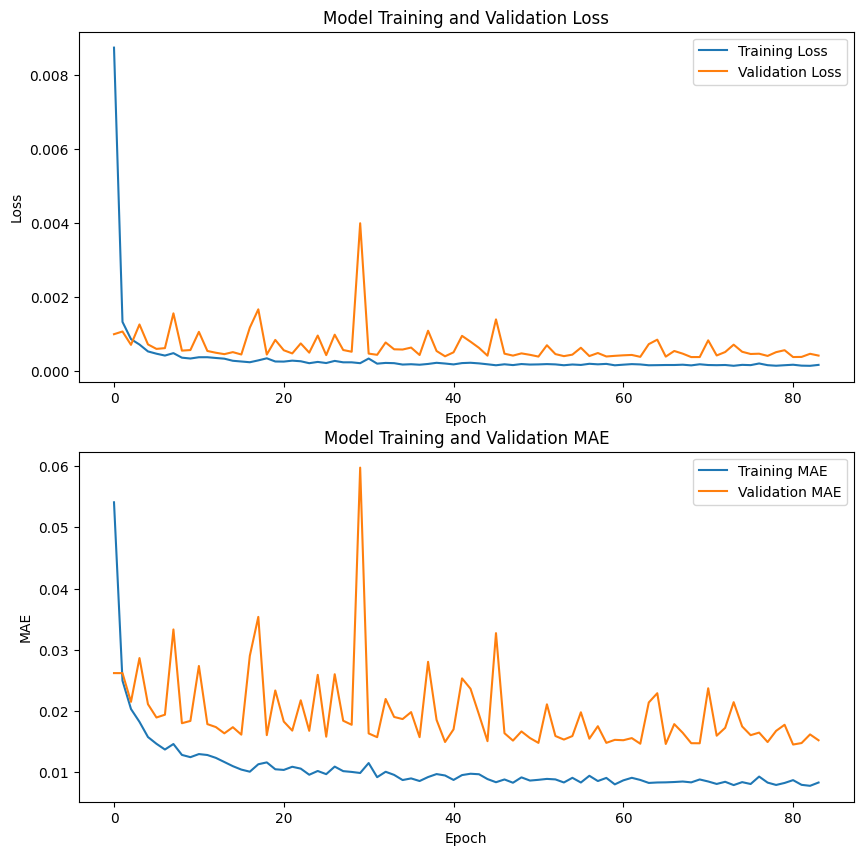

145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

Predicting 2 days into the future:
Validation Set Metrics:


,0
Model,RNN
Day 1 MSE,5.903691
Day 1 RMSE,2.429751
Day 1 MAE,1.871376
Day 1 R2,0.975776
Day 2 MSE,10.561154
Day 2 RMSE,3.249793
Day 2 MAE,2.46456
Day 2 R2,0.95626


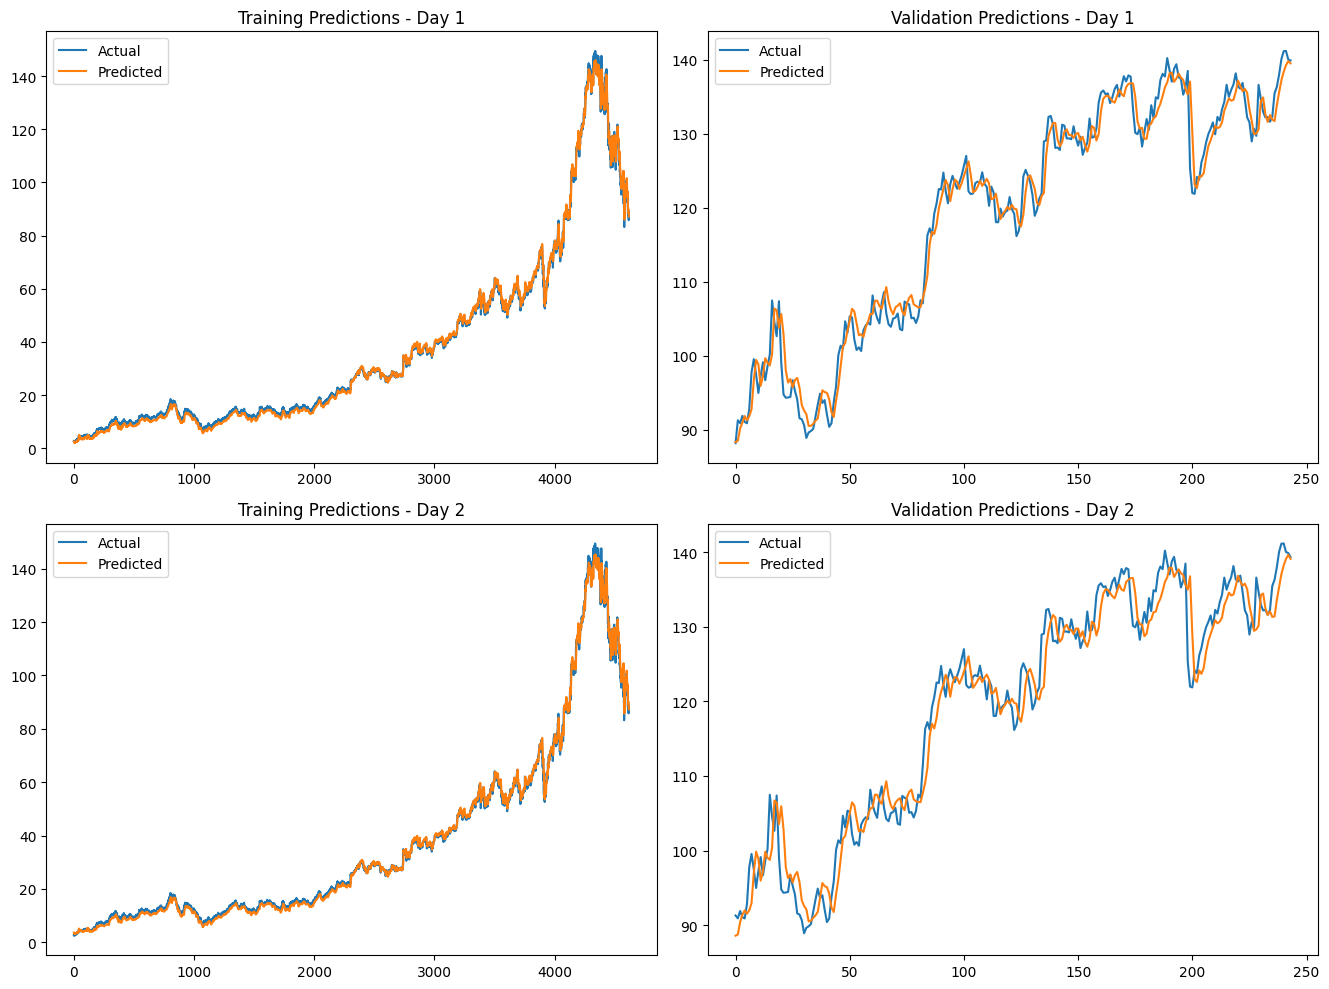

In [ ]:
df_eval_RNN = evaluate_model(modelRNN, historyRNN, X_train, y_train, X_val, y_val, target_scaler, predict_days, model_type=ModelType.RNN)

## 5.2. LSTM Model

In [ ]:
modelLSTM = build_model(look_back, X_train.shape[2], model_config_baseline, type=ModelType.LSTM)

historyLSTM, modelLSTM = fit_model(modelLSTM, X_train, y_train, X_val, y_val, fit_config_baseline)


Epoch 1/200
145/145 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0266 - mae: 0.0849 - val_loss: 0.0020 - val_mae: 0.0381
Epoch 2/200
145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3.7020e-04 - mae: 0.0120 - val_loss: 8.2634e-04 - val_mae: 0.0227
Epoch 3/200
145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3.2645e-04 - mae: 0.0108 - val_loss: 7.6763e-04 - val_mae: 0.0215
Epoch 4/200
145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3.6283e-04 - mae: 0.0110 - val_loss: 8.3819e-04 - val_mae: 0.0225
Epoch 5/200
145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.7307e-04 - mae: 0.0098 - val_loss: 9.4957e-04 - val_mae: 0.0241
Epoch 6/200
145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.6445e-04 - mae: 0.0097 - val_loss: 7.4762e-04 - val_mae: 0.0213
Epoch 7/200
145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.7516e-04 - mae: 0.0097 - val_loss: 7.2536e-04 - val_mae: 0.0208
Epoch 8/200
145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3.5350e-04 - mae: 0.0115 - val_loss: 0.0014 - val_mae: 0.0

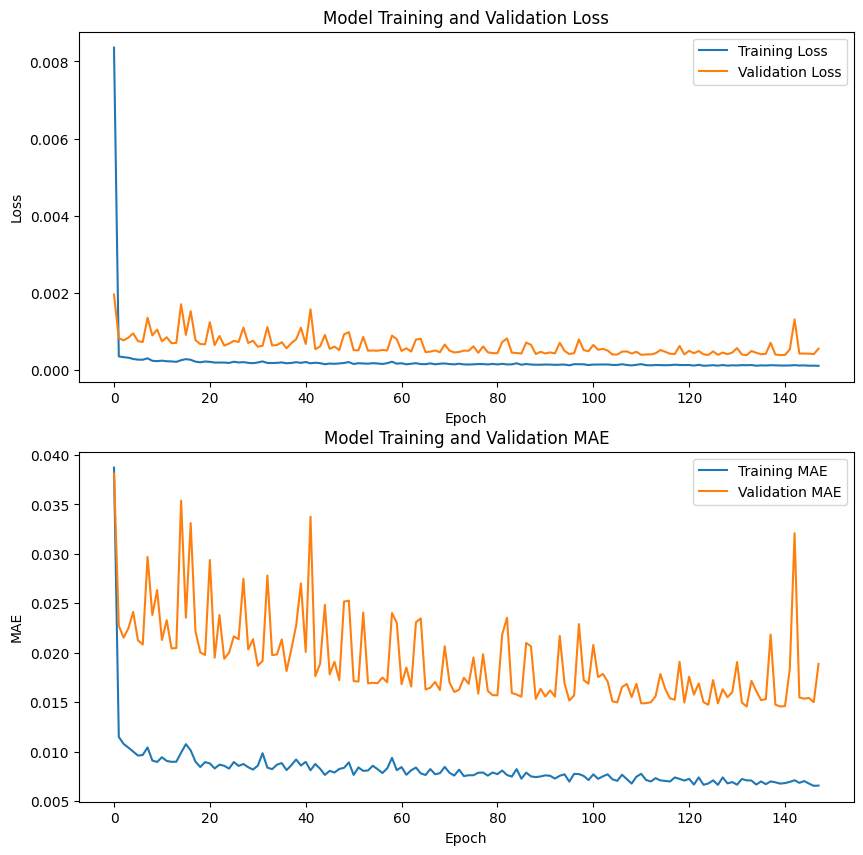

145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 

Predicting 2 days into the future:
Validation Set Metrics:


,0
Model,LSTM
Day 1 MSE,5.980404
Day 1 RMSE,2.445487
Day 1 MAE,1.822504
Day 1 R2,0.975461
Day 2 MSE,10.642548
Day 2 RMSE,3.262292
Day 2 MAE,2.460967
Day 2 R2,0.955923


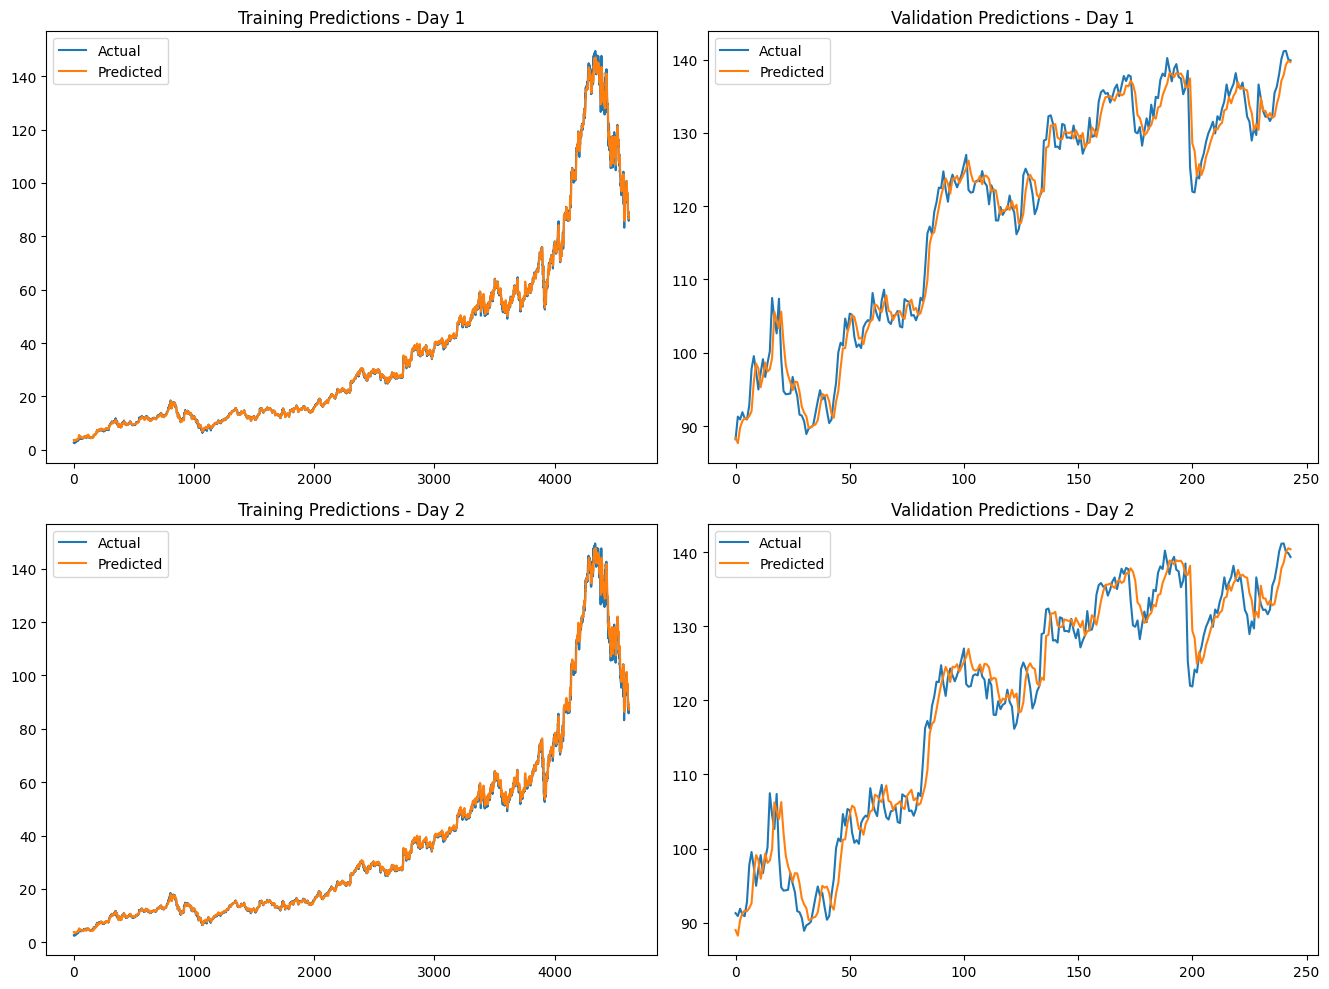

In [ ]:
df_eval_LSTM = evaluate_model(modelLSTM, historyLSTM, X_train, y_train, X_val, y_val, target_scaler, predict_days, model_type=ModelType.LSTM)

## 5.3. GRU Model

In [ ]:
modelGRU = build_model(look_back, X_train.shape[2], model_config_baseline, type=ModelType.GRU)

historyGRU, modelGRU = fit_model(modelGRU, X_train, y_train, X_val, y_val, fit_config_baseline)

Epoch 1/200
145/145 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 0.0280 - mae: 0.0897 - val_loss: 6.4013e-04 - val_mae: 0.0193
Epoch 2/200
145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 5.3462e-04 - mae: 0.0138 - val_loss: 7.2452e-04 - val_mae: 0.0213
Epoch 3/200
145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3.7695e-04 - mae: 0.0116 - val_loss: 9.2317e-04 - val_mae: 0.0244
Epoch 4/200
145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3.0662e-04 - mae: 0.0108 - val_loss: 6.6876e-04 - val_mae: 0.0201
Epoch 5/200
145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.9143e-04 - mae: 0.0105 - val_loss: 6.3088e-04 - val_mae: 0.0194
Epoch 6/200
145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.8869e-04 - mae: 0.0105 - val_loss: 9.7027e-04 - val_mae: 0.0246
Epoch 7/200
145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.8371e-04 - mae: 0.0098 - val_loss: 7.5007e-04 - val_mae: 0.0212
Epoch 8/200
145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.3982e-04 - mae: 0.0092 - val_loss: 0.0014 - val_mae

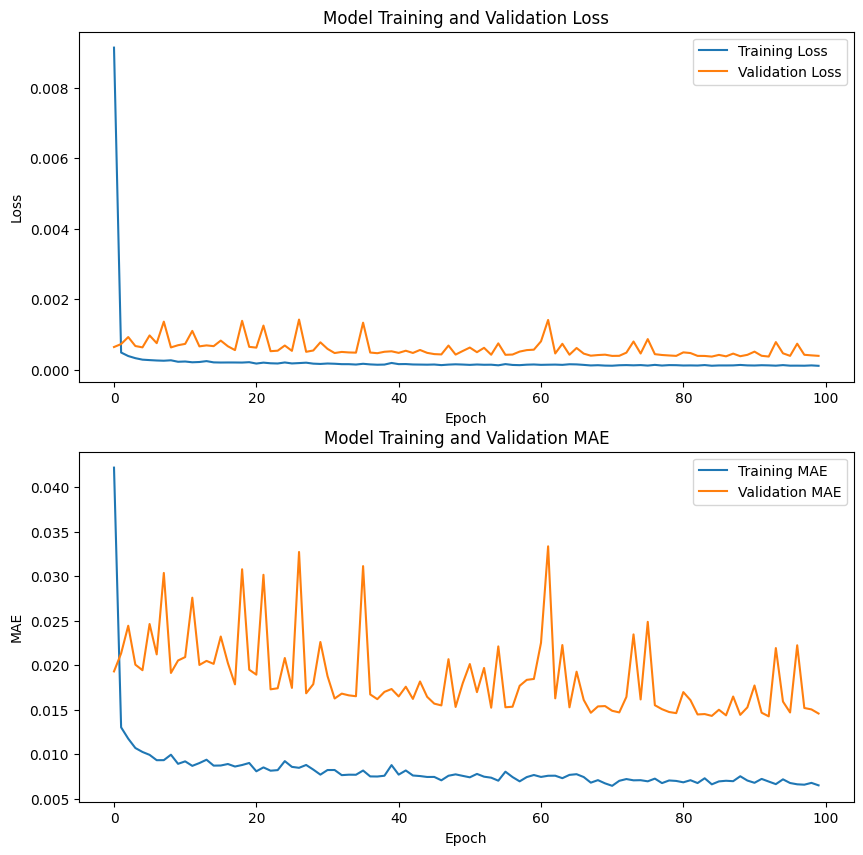

145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

Predicting 2 days into the future:
Validation Set Metrics:


,0
Model,GRU
Day 1 MSE,5.515354
Day 1 RMSE,2.348479
Day 1 MAE,1.766555
Day 1 R2,0.977369
Day 2 MSE,10.426038
Day 2 RMSE,3.228938
Day 2 MAE,2.441254
Day 2 R2,0.95682


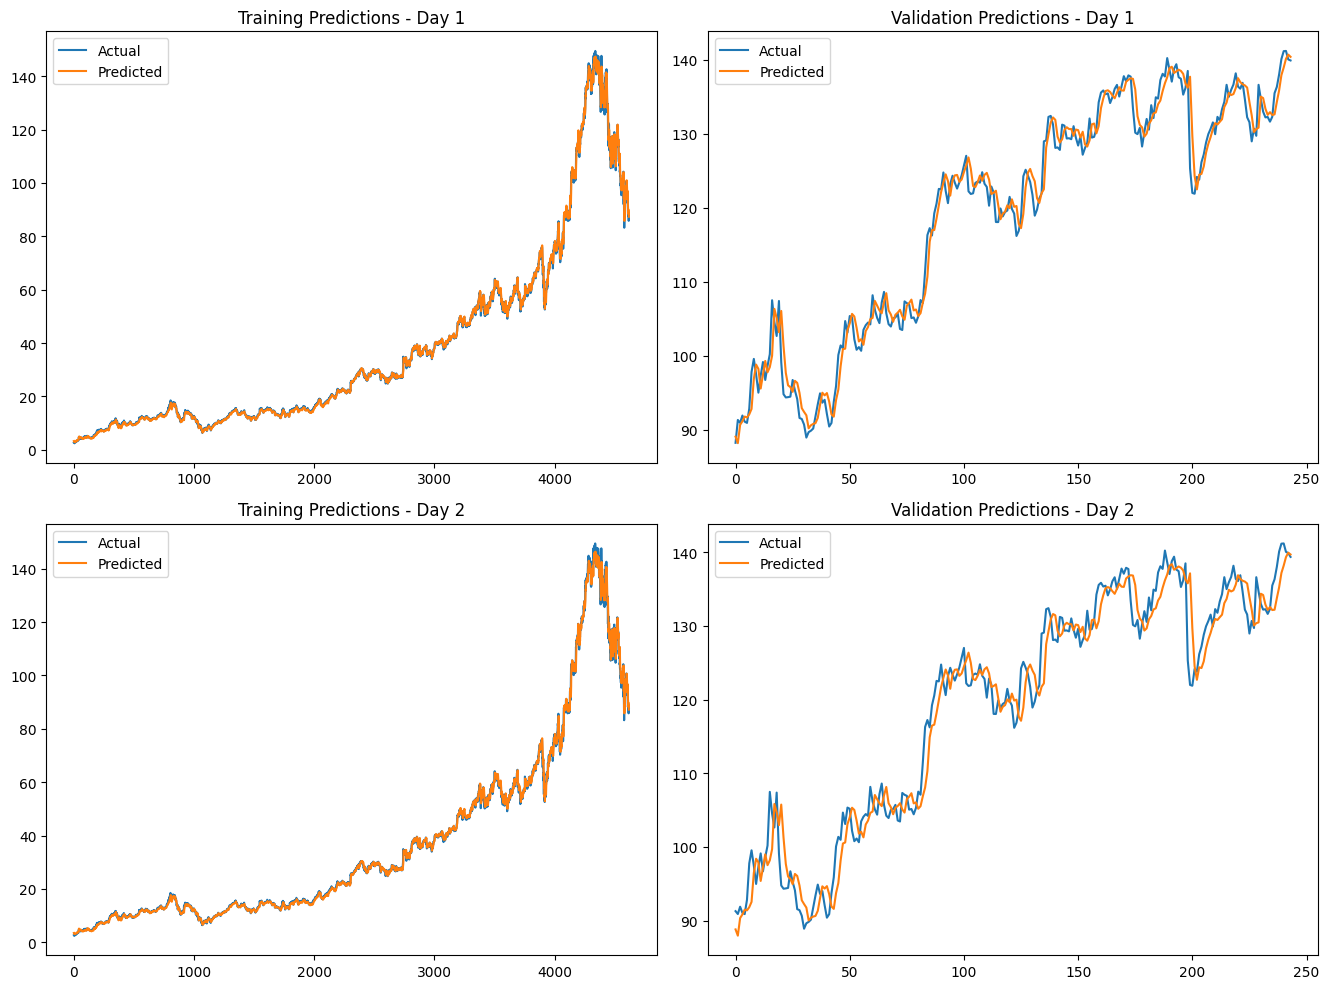

In [ ]:
df_eval_GRU = evaluate_model(modelGRU, historyGRU, X_train, y_train, X_val, y_val, target_scaler, predict_days, model_type=ModelType.GRU)

## 5.4. Compare Base models

In [ ]:
# Compare the evaluation metrics of the RNN, LSTM, and GRU models
df_eval = pd.concat([df_eval_RNN, df_eval_LSTM, df_eval_GRU], axis=0)
df_eval.index = df_eval['Model']
df_eval.drop(columns='Model', inplace=True)

display(df_eval)

,Day 1 MSE,Day 1 RMSE,Day 1 MAE,Day 1 R2,Day 2 MSE,Day 2 RMSE,Day 2 MAE,Day 2 R2
Model,,,,,,,,
RNN,5.903691,2.429751,1.871376,0.975776,10.561154,3.249793,2.464560,0.956260
LSTM,5.980404,2.445487,1.822504,0.975461,10.642548,3.262292,2.460967,0.955923
GRU,5.515354,2.348479,1.766555,0.977369,10.426038,3.228938,2.441254,0.956820


GRU will be chosen as it has the overall best performance on all th metrics.

# 6. Hyperparameter Tuning

In [18]:
def evaluate_configuration(config_params):
    """
    Evaluate a single configuration for hyperparameter tuning

    Args:
    config_params (tuple): Contains all necessary parameters for model evaluation

    Returns:
    dict: Configuration results including RMSE and configuration details
    """
    (units1, units2, dropout,
     dense_units, lr, batch_size, look_back) = config_params

    _, _, feature_scaler, target_scaler = prepare_data(train_data, look_back, predict_days)

    # Prepare data using the same scaler
    X_train, y_train, _, _ = prepare_data(train_data, look_back, predict_days, feature_scaler, target_scaler)
    X_val, y_val, _, _ = prepare_data(val_data, look_back, predict_days, feature_scaler, target_scaler)

    # Construct model configuration
    model_config = {
        'recurrent_layers': [
            {'units': units1, 'dropout': dropout},
            {'units': units2, 'dropout': dropout} #Fixed: Before dropout was being assigned to dense_units
        ],
        'dense_layers': [
            {'units': dense_unit, 'activation': 'relu'} for dense_unit in dense_units
        ],
        'output_units': predict_days,
        'learning_rate': lr,
        'look_back': look_back
    }

    fit_config = {
        'epochs': 200,
        'batch_size': batch_size
    }

    # Build and train model
    model = build_model(look_back, X_train.shape[2], model_config)
    history, trained_model = fit_model(model, X_train, y_train, X_val, y_val, fit_config)

    # Predict and calculate RMSE
    y_pred = trained_model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))

    # Store results
    return {
        'config': model_config,
        'fit_config': fit_config,
        'rmse': rmse,
        'history': history,
        'model': trained_model
    }


def grid_search_gru_hyperparameters(parameters):
    recurrent_units_options = parameters.get('recurrent_units', [32, 64, 128])
    recurrent_units_options_2 = parameters.get('recurrent_units_2', recurrent_units_options)
    dropout_options = parameters.get('dropout', [0, 0.2, 0.3])
    dense_units_options = parameters.get('dense_units', [[], [16], [32], [64], [32, 16]])
    learning_rates = parameters.get('learning_rates', [0.001, 0.01, 0.0001])
    batch_sizes = parameters.get('batch_sizes', [32, 64, 128])
    look_back = parameters.get('look_back', [3, 5, 10])

    # Generate all possible combinations
    configurations = list(itertools.product(
        recurrent_units_options,  # units1
        recurrent_units_options_2,  # units2
        dropout_options,          # dropout
        dense_units_options,      # dense_units
        learning_rates,           # lr
        batch_sizes,              # batch_size
        look_back                 # look_back
    ))

    # Prepare arguments for parallel processing
    eval_args = [config
                 for config in configurations]

    # Use all available cores for parallel processing
    num_cores = multiprocessing.cpu_count()

    # Store results
    best_rmse = float('inf')
    best_config = None

    # Use tqdm for progress tracking with multiprocessing
    with multiprocessing.Pool(num_cores) as pool:
        # Wrap the configurations with tqdm for progress bar
        for result in tqdm(pool.imap(evaluate_configuration, eval_args),
                           total=len(configurations),
                           desc="Hyperparameter Tuning"):

            # Update best model if necessary
            if result['rmse'] < best_rmse:
                best_rmse = result['rmse']
                best_config = {**result['config'], **result['fit_config']}
                best_model = result['model']
                best_history = result['history']

    print(f"Best RMSE: {best_rmse}")
    print(f"Best Configuration: {best_config}")
    return best_config, best_model, best_history

In [ ]:
parameter = {
    'recurrent_units': [32, 64, 128],
    'dense_units': [[], [16], [32], [64], [32, 16]],
    'dropout': [0.2],
    'learning_rates': [0.001],
    'batch_sizes': [64],
    'look_back': [5]
}
best_config, best_model, best_history = grid_search_gru_hyperparameters(parameter)

Hyperparameter Tuning:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 1/200
Epoch 1/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 14s 71ms/step - loss: 0.0611 - mae: 0.1681 - val_loss: 0.0012 - val_mae: 0.0280
Epoch 2/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0111 - mae: 0.0717 - val_loss: 7.4941e-04 - val_mae: 0.0220
Epoch 3/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 15s 74ms/step - loss: 0.0428 - mae: 0.1259 - val_loss: 0.0077 - val_mae: 0.0764
Epoch 2/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0068 - mae: 0.0550 - val_loss: 7.4845e-04 - val_mae: 0.0217
Epoch 4/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0050 - mae: 0.0462 - val_loss: 5.9079e-04 - val_mae: 0.0190
Epoch 5/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0070 - mae: 0.0551 - val_loss: 0.0014 - val_mae: 0.0311
Epoch 3/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0046 - mae: 0.0425 - val_loss: 9.4375e-04 - val_mae: 0.0245
Epoch 6/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0042 - mae: 0.0428 - val_loss: 0.0026 - val_mae: 0.0435
Epoch 4/200
73/73 ━━━━━━━━━━━━━

Hyperparameter Tuning:   2%|▏         | 1/45 [01:21<1:00:06, 81.97s/it]

73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 5.3525e-04 - mae: 0.0155 - val_loss: 7.9595e-04 - val_mae: 0.0232
Epoch 85/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 6.1526e-04 - mae: 0.0164 - val_loss: 4.8727e-04 - val_mae: 0.0169
Epoch 86/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 5.2844e-04 - mae: 0.0154 - val_loss: 6.1156e-04 - val_mae: 0.0198
Epoch 87/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 5.1719e-04 - mae: 0.0151 - val_loss: 4.2889e-04 - val_mae: 0.0159
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 188ms/step
69/73 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0414 - mae: 0.1300

Hyperparameter Tuning:   4%|▍         | 2/45 [01:29<27:29, 38.37s/it]  

Epoch 1/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 18s 87ms/step - loss: 0.0401 - mae: 0.1272 - val_loss: 0.0046 - val_mae: 0.0574
Epoch 2/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0060 - mae: 0.0504 - val_loss: 0.0016 - val_mae: 0.0324
Epoch 3/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0041 - mae: 0.0403 - val_loss: 0.0018 - val_mae: 0.0373
Epoch 4/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0032 - mae: 0.0351 - val_loss: 0.0019 - val_mae: 0.0358
Epoch 5/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0024 - mae: 0.0308 - val_loss: 0.0016 - val_mae: 0.0330
Epoch 6/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0022 - mae: 0.0296 - val_loss: 0.0035 - val_mae: 0.0523
Epoch 7/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0021 - mae: 0.0277 - val_loss: 0.0031 - val_mae: 0.0477
Epoch 8/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0015 - mae: 0.0250 - val_loss: 0.0056 - val_mae: 0.0675
Epoch 9/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss:

Hyperparameter Tuning:   7%|▋         | 3/45 [02:03<25:14, 36.05s/it]

73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0010 - mae: 0.0205 - val_loss: 0.0032 - val_mae: 0.0527
Epoch 18/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 8.3092e-04 - mae: 0.0188 - val_loss: 0.0054 - val_mae: 0.0693
Epoch 19/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 7.3250e-04 - mae: 0.0176 - val_loss: 0.0015 - val_mae: 0.0335
Epoch 20/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 8.7457e-04 - mae: 0.0190 - val_loss: 0.0109 - val_mae: 0.1009
Epoch 21/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 8.1792e-04 - mae: 0.0185 - val_loss: 0.0075 - val_mae: 0.0829
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 192ms/step
Epoch 1/200


Hyperparameter Tuning:   9%|▉         | 4/45 [02:10<16:51, 24.67s/it]

73/73 ━━━━━━━━━━━━━━━━━━━━ 17s 80ms/step - loss: 0.0422 - mae: 0.1243 - val_loss: 0.0053 - val_mae: 0.0600
Epoch 2/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0043 - mae: 0.0449 - val_loss: 0.0079 - val_mae: 0.0837
Epoch 3/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0031 - mae: 0.0359 - val_loss: 0.0085 - val_mae: 0.0872
Epoch 4/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0022 - mae: 0.0309 - val_loss: 0.0049 - val_mae: 0.0654
Epoch 5/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0018 - mae: 0.0284 - val_loss: 0.0070 - val_mae: 0.0799
Epoch 6/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0016 - mae: 0.0255 - val_loss: 0.0108 - val_mae: 0.1005
Epoch 7/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0015 - mae: 0.0254 - val_loss: 0.0109 - val_mae: 0.1010
Epoch 8/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0012 - mae: 0.0231 - val_loss: 0.0108 - val_mae: 0.1010
Epoch 9/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0016 - mae: 0

73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.2215e-04 - mae: 0.0180 - val_loss: 8.5051e-04 - val_mae: 0.0241
Epoch 28/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 9.2243e-04 - mae: 0.0182 - val_loss: 0.0012 - val_mae: 0.0290
Epoch 29/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 8.8991e-04 - mae: 0.0180 - val_loss: 0.0012 - val_mae: 0.0284
Epoch 30/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.3948e-04 - mae: 0.0185 - val_loss: 6.1527e-04 - val_mae: 0.0198
Epoch 31/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 8.8442e-04 - mae: 0.0181 - val_loss: 5.0497e-04 - val_mae: 0.0172
Epoch 32/200
Epoch 1/200


Hyperparameter Tuning:  11%|█         | 5/45 [02:46<19:13, 28.84s/it]

73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 8.6336e-04 - mae: 0.0179 - val_loss: 6.2804e-04 - val_mae: 0.0194
Epoch 33/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 8.7142e-04 - mae: 0.0180 - val_loss: 7.6761e-04 - val_mae: 0.0222
Epoch 34/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 7.8863e-04 - mae: 0.0171 - val_loss: 9.4767e-04 - val_mae: 0.0258
Epoch 35/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 7.1944e-04 - mae: 0.0166 - val_loss: 4.5811e-04 - val_mae: 0.0163
Epoch 36/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 7.0647e-04 - mae: 0.0165 - val_loss: 4.3975e-04 - val_mae: 0.0159
Epoch 37/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 7.3999e-04 - mae: 0.0165 - val_loss: 0.0022 - val_mae: 0.0423
Epoch 38/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 8.5675e-04 - mae: 0.0180 - val_loss: 4.5919e-04 - val_mae: 0.0163
Epoch 39/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 6.6085e-04 - mae: 0.0161 - val_loss: 0.0012 - val_mae: 0.0289
Epoch 40

73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0026 - mae: 0.0319 - val_loss: 5.1275e-04 - val_mae: 0.0177
Epoch 4/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0020 - mae: 0.0283 - val_loss: 6.1775e-04 - val_mae: 0.0191
Epoch 5/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0015 - mae: 0.0240 - val_loss: 4.9911e-04 - val_mae: 0.0169
Epoch 6/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0014 - mae: 0.0232 - val_loss: 9.0112e-04 - val_mae: 0.0242
Epoch 7/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0012 - mae: 0.0217 - val_loss: 4.6044e-04 - val_mae: 0.0163
Epoch 8/200
Epoch 1/200


Hyperparameter Tuning:  13%|█▎        | 6/45 [03:05<16:33, 25.48s/it]

73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0013 - mae: 0.0220 - val_loss: 0.0018 - val_mae: 0.0376
Epoch 9/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0011 - mae: 0.0205 - val_loss: 0.0030 - val_mae: 0.0507
Epoch 10/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0013 - mae: 0.0226 - val_loss: 4.5335e-04 - val_mae: 0.0161
Epoch 11/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0010 - mae: 0.0200 - val_loss: 0.0042 - val_mae: 0.0615
Epoch 12/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0013 - mae: 0.0217 - val_loss: 0.0017 - val_mae: 0.0370
Epoch 13/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 9.8630e-04 - mae: 0.0196 - val_loss: 5.2942e-04 - val_mae: 0.0176
Epoch 14/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 8.3928e-04 - mae: 0.0185 - val_loss: 0.0020 - val_mae: 0.0398
Epoch 15/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 8.2946e-04 - mae: 0.0178 - val_loss: 0.0011 - val_mae: 0.0281
Epoch 16/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/s

73/73 ━━━━━━━━━━━━━━━━━━━━ 17s 90ms/step - loss: 0.0529 - mae: 0.1401 - val_loss: 0.0022 - val_mae: 0.0395
Epoch 2/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step
Epoch 1/200


Hyperparameter Tuning:  16%|█▌        | 7/45 [03:22<14:26, 22.80s/it]

73/73 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - loss: 0.0060 - mae: 0.0516 - val_loss: 0.0068 - val_mae: 0.0700
Epoch 3/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0036 - mae: 0.0385 - val_loss: 0.0013 - val_mae: 0.0302
Epoch 4/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0026 - mae: 0.0328 - val_loss: 0.0038 - val_mae: 0.0512
Epoch 5/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0021 - mae: 0.0294 - val_loss: 0.0034 - val_mae: 0.0521
Epoch 6/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 11s 92ms/step - loss: 0.0421 - mae: 0.1282 - val_loss: 0.0050 - val_mae: 0.0627
Epoch 2/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0021 - mae: 0.0286 - val_loss: 0.0029 - val_mae: 0.0426
66/73 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0047 - mae: 0.0458Epoch 7/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0047 - mae: 0.0455 - val_loss: 0.0076 - val_mae: 0.0700
Epoch 3/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0020 - mae: 0.0280 - val_loss: 6.0630e-04 - val_mae: 0.019

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 174ms/step
Epoch 1/200


Hyperparameter Tuning:  18%|█▊        | 8/45 [04:02<17:17, 28.04s/it]

73/73 ━━━━━━━━━━━━━━━━━━━━ 20s 102ms/step - loss: 0.0244 - mae: 0.0966 - val_loss: 0.0195 - val_mae: 0.1303
Epoch 2/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 13s 86ms/step - loss: 0.0948 - mae: 0.1999 - val_loss: 0.0039 - val_mae: 0.0507
Epoch 2/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0089 - mae: 0.0637 - val_loss: 0.0018 - val_mae: 0.0352
Epoch 3/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0059 - mae: 0.0490 - val_loss: 0.0026 - val_mae: 0.0409
Epoch 4/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0036 - mae: 0.0392 - val_loss: 0.0011 - val_mae: 0.0273
Epoch 5/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0031 - mae: 0.0356 - val_loss: 0.0011 - val_mae: 0.0276
Epoch 6/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0026 - mae: 0.0326 - val_loss: 0.0011 - val_mae: 0.0256
Epoch 7/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0021 - mae: 0.0292 - val_loss: 0.0014 - val_mae: 0.0303
Epoch 8/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0018 - mae

Hyperparameter Tuning:  22%|██▏       | 10/45 [04:47<14:49, 25.41s/it]

73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 5.2590e-04 - mae: 0.0146 - val_loss: 9.5545e-04 - val_mae: 0.0252
Epoch 50/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.0304e-04 - mae: 0.0146 - val_loss: 5.6262e-04 - val_mae: 0.0181
Epoch 51/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 4.5903e-04 - mae: 0.0140 - val_loss: 0.0021 - val_mae: 0.0406
Epoch 52/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.4903e-04 - mae: 0.0146 - val_loss: 8.0025e-04 - val_mae: 0.0228
Epoch 53/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.2160e-04 - mae: 0.0143 - val_loss: 6.5352e-04 - val_mae: 0.0200
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step


Hyperparameter Tuning:  24%|██▍       | 11/45 [04:52<11:32, 20.38s/it]

Epoch 1/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 18s 135ms/step - loss: 0.0665 - mae: 0.1493 - val_loss: 0.0030 - val_mae: 0.0419
Epoch 2/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0063 - mae: 0.0544 - val_loss: 0.0013 - val_mae: 0.0298
Epoch 3/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0039 - mae: 0.0399 - val_loss: 0.0035 - val_mae: 0.0489
Epoch 4/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0028 - mae: 0.0337 - val_loss: 0.0045 - val_mae: 0.0621
Epoch 5/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0020 - mae: 0.0296 - val_loss: 0.0057 - val_mae: 0.0710
Epoch 6/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0020 - mae: 0.0277 - val_loss: 0.0014 - val_mae: 0.0303
Epoch 7/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0016 - mae: 0.0250 - val_loss: 0.0012 - val_mae: 0.0276
Epoch 8/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0017 - mae: 0.0258 - val_loss: 5.6203e-04 - val_mae: 0.0182
Epoch 9/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss

Hyperparameter Tuning:  27%|██▋       | 12/45 [05:23<12:46, 23.24s/it]

73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0013 - mae: 0.0238 - val_loss: 7.2508e-04 - val_mae: 0.0211
Epoch 8/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0012 - mae: 0.0224 - val_loss: 0.0012 - val_mae: 0.0292
Epoch 9/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 9.8513e-04 - mae: 0.0206 - val_loss: 8.9887e-04 - val_mae: 0.0246
Epoch 10/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0011 - mae: 0.0207 - val_loss: 6.3389e-04 - val_mae: 0.0197
Epoch 11/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0010 - mae: 0.0202 - val_loss: 0.0023 - val_mae: 0.0428
Epoch 12/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 8.0575e-04 - mae: 0.0184 - val_loss: 6.2520e-04 - val_mae: 0.0192
Epoch 13/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 9.0135e-04 - mae: 0.0190 - val_loss: 5.2640e-04 - val_mae: 0.0174
Epoch 14/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7.0817e-04 - mae: 0.0169 - val_loss: 9.5187e-04 - val_mae: 0.0250
Epoch 15/200
73/73 ━━━━━━━━━━━

Hyperparameter Tuning:  29%|██▉       | 13/45 [05:45<12:08, 22.76s/it]

73/73 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0034 - mae: 0.0377 - val_loss: 0.0058 - val_mae: 0.0708
Epoch 3/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0021 - mae: 0.0301 - val_loss: 0.0018 - val_mae: 0.0355
Epoch 4/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0017 - mae: 0.0260 - val_loss: 8.9891e-04 - val_mae: 0.0238
Epoch 5/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0013 - mae: 0.0235 - val_loss: 0.0011 - val_mae: 0.0274
Epoch 6/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0012 - mae: 0.0217 - val_loss: 0.0011 - val_mae: 0.0265
Epoch 7/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0011 - mae: 0.0202 - val_loss: 6.9260e-04 - val_mae: 0.0206
Epoch 8/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 9.0533e-04 - mae: 0.0189 - val_loss: 7.0956e-04 - val_mae: 0.0207
Epoch 9/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 9.7956e-04 - mae: 0.0190 - val_loss: 7.2878e-04 - val_mae: 0.0215
Epoch 10/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step 

Hyperparameter Tuning:  31%|███       | 14/45 [06:09<11:58, 23.19s/it]

73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 8.7977e-04 - mae: 0.0185 - val_loss: 0.0024 - val_mae: 0.0436
Epoch 12/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.5223e-04 - mae: 0.0178 - val_loss: 9.4660e-04 - val_mae: 0.0238
Epoch 13/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 6.4283e-04 - mae: 0.0159 - val_loss: 5.7885e-04 - val_mae: 0.0184
Epoch 14/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 8.5103e-04 - mae: 0.0181 - val_loss: 0.0012 - val_mae: 0.0283
Epoch 15/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7.3270e-04 - mae: 0.0168 - val_loss: 0.0019 - val_mae: 0.0378
Epoch 16/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 7.2288e-04 - mae: 0.0169 - val_loss: 6.1060e-04 - val_mae: 0.0194
Epoch 17/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7.2216e-04 - mae: 0.0169 - val_loss: 7.5450e-04 - val_mae: 0.0217
Epoch 18/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 6.0967e-04 - mae: 0.0154 - val_loss: 7.4893e-04 - val_mae: 0.0219
Epoch 19/200
73/7

Hyperparameter Tuning:  33%|███▎      | 15/45 [06:33<11:42, 23.43s/it]

73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0091 - mae: 0.0620 - val_loss: 0.0013 - val_mae: 0.0298
Epoch 4/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0068 - mae: 0.0524 - val_loss: 0.0016 - val_mae: 0.0336
Epoch 5/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0050 - mae: 0.0453 - val_loss: 0.0011 - val_mae: 0.0266
Epoch 6/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0045 - mae: 0.0422 - val_loss: 0.0012 - val_mae: 0.0275
Epoch 7/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0037 - mae: 0.0386 - val_loss: 9.7563e-04 - val_mae: 0.0248
Epoch 8/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0034 - mae: 0.0367 - val_loss: 5.9852e-04 - val_mae: 0.0190
Epoch 9/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0035 - mae: 0.0360 - val_loss: 9.3035e-04 - val_mae: 0.0249
Epoch 10/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0025 - mae: 0.0310 - val_loss: 0.0018 - val_mae: 0.0362
Epoch 11/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.

Hyperparameter Tuning:  36%|███▌      | 16/45 [07:06<12:37, 26.11s/it]

72/73 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 7.6801e-04 - mae: 0.0173Epoch 1/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 7.6870e-04 - mae: 0.0173 - val_loss: 8.6730e-04 - val_mae: 0.0244
Epoch 21/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 9.9376e-04 - mae: 0.0190 - val_loss: 5.8695e-04 - val_mae: 0.0194
Epoch 22/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 8.5289e-04 - mae: 0.0181 - val_loss: 0.0016 - val_mae: 0.0357
Epoch 23/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 8.4572e-04 - mae: 0.0169 - val_loss: 0.0025 - val_mae: 0.0467
Epoch 24/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 7.0263e-04 - mae: 0.0167 - val_loss: 0.0018 - val_mae: 0.0378
Epoch 25/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7.2692e-04 - mae: 0.0168 - val_loss: 0.0011 - val_mae: 0.0281
Epoch 26/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8.8142e-04 - mae: 0.0175 - val_loss: 0.0017 - val_mae: 0.0362
Epoch 27/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 7.8

Hyperparameter Tuning:  38%|███▊      | 17/45 [07:16<09:57, 21.33s/it]

Epoch 1/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 13s 63ms/step - loss: 0.0478 - mae: 0.1325 - val_loss: 0.0053 - val_mae: 0.0632
Epoch 2/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0055 - mae: 0.0497 - val_loss: 0.0017 - val_mae: 0.0352
Epoch 3/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0040 - mae: 0.0407 - val_loss: 0.0019 - val_mae: 0.0376
Epoch 4/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0028 - mae: 0.0345 - val_loss: 0.0039 - val_mae: 0.0591
Epoch 5/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0026 - mae: 0.0325 - val_loss: 0.0042 - val_mae: 0.0593
Epoch 6/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0022 - mae: 0.0298 - val_loss: 0.0056 - val_mae: 0.0711
Epoch 7/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0018 - mae: 0.0262 - val_loss: 0.0036 - val_mae: 0.0551
Epoch 8/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0015 - mae: 0.0245 - val_loss: 0.0022 - val_mae: 0.0402
Epoch 9/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - l

Hyperparameter Tuning:  40%|████      | 18/45 [07:52<11:39, 25.90s/it]

73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 9.8043e-04 - mae: 0.0191 - val_loss: 0.0038 - val_mae: 0.0569
Epoch 19/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 7.9447e-04 - mae: 0.0177 - val_loss: 0.0116 - val_mae: 0.1047
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step


Hyperparameter Tuning:  42%|████▏     | 19/45 [07:56<08:18, 19.15s/it]

Epoch 1/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 13s 100ms/step - loss: 0.1154 - mae: 0.2226 - val_loss: 0.0296 - val_mae: 0.1394
Epoch 2/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 17s 110ms/step - loss: 0.0303 - mae: 0.1064 - val_loss: 0.0153 - val_mae: 0.1165
Epoch 2/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 0.0041 - mae: 0.0408 - val_loss: 0.0047 - val_mae: 0.0586
Epoch 3/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0025 - mae: 0.0325 - val_loss: 6.9363e-04 - val_mae: 0.0215
Epoch 4/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0022 - mae: 0.0290 - val_loss: 0.0026 - val_mae: 0.0460
Epoch 5/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - loss: 0.0160 - mae: 0.0828 - val_loss: 0.0011 - val_mae: 0.0250
Epoch 3/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0017 - mae: 0.0264 - val_loss: 0.0019 - val_mae: 0.0377
Epoch 6/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0016 - mae: 0.0253 - val_loss: 0.0046 - val_mae: 0.0642
Epoch 7/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step -

Hyperparameter Tuning:  44%|████▍     | 20/45 [08:34<10:24, 24.97s/it]

73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0013 - mae: 0.0215 - val_loss: 0.0016 - val_mae: 0.0345
Epoch 21/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0012 - mae: 0.0208 - val_loss: 8.2975e-04 - val_mae: 0.0224
Epoch 22/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0013 - mae: 0.0223 - val_loss: 7.5326e-04 - val_mae: 0.0212
Epoch 23/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0011 - mae: 0.0198 - val_loss: 9.0360e-04 - val_mae: 0.0237
Epoch 24/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0012 - mae: 0.0209 - val_loss: 6.1236e-04 - val_mae: 0.0191
Epoch 25/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0012 - mae: 0.0204 - val_loss: 6.4118e-04 - val_mae: 0.0197
Epoch 26/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 9.5446e-04 - mae: 0.0186 - val_loss: 6.6452e-04 - val_mae: 0.0199
Epoch 27/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 9.9513e-04 - mae: 0.0189 - val_loss: 5.8153e-04 - val_mae: 0.0186
Epoch 28/200
73/73 ━━━━━━━━━━━━━━

Hyperparameter Tuning:  47%|████▋     | 21/45 [08:55<09:26, 23.61s/it]

Epoch 1/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0011 - mae: 0.0207 - val_loss: 0.0016 - val_mae: 0.0348
Epoch 9/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0010 - mae: 0.0199 - val_loss: 7.3576e-04 - val_mae: 0.0215
Epoch 10/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0012 - mae: 0.0204 - val_loss: 0.0013 - val_mae: 0.0309
Epoch 11/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 9.9385e-04 - mae: 0.0193 - val_loss: 4.6574e-04 - val_mae: 0.0165
Epoch 12/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.8741e-04 - mae: 0.0170 - val_loss: 0.0032 - val_mae: 0.0523
Epoch 13/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0012 - mae: 0.0207 - val_loss: 9.2186e-04 - val_mae: 0.0254
Epoch 14/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 8.1184e-04 - mae: 0.0174 - val_loss: 4.9327e-04 - val_mae: 0.0172
Epoch 15/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7.1688e-04 - mae: 0.0166 - val_loss: 6.2944e-04 - val_mae: 0.0196
Epoch 16/200
73/73 ━━━

Hyperparameter Tuning:  49%|████▉     | 22/45 [09:23<09:32, 24.90s/it]

73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0020 - mae: 0.0282 - val_loss: 0.0027 - val_mae: 0.0455
Epoch 6/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0018 - mae: 0.0274 - val_loss: 0.0017 - val_mae: 0.0357
Epoch 7/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0016 - mae: 0.0251 - val_loss: 5.9079e-04 - val_mae: 0.0192
Epoch 8/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0013 - mae: 0.0235 - val_loss: 5.7248e-04 - val_mae: 0.0188
Epoch 9/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0013 - mae: 0.0232 - val_loss: 0.0030 - val_mae: 0.0499
Epoch 10/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0011 - mae: 0.0215 - val_loss: 5.9566e-04 - val_mae: 0.0194
Epoch 11/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0011 - mae: 0.0212 - val_loss: 0.0016 - val_mae: 0.0343
Epoch 12/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0011 - mae: 0.0205 - val_loss: 5.8693e-04 - val_mae: 0.0188
Epoch 13/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/ste

Hyperparameter Tuning:  51%|█████     | 23/45 [09:52<09:36, 26.19s/it]

Epoch 1/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0014 - mae: 0.0235 - val_loss: 0.0037 - val_mae: 0.0563
Epoch 7/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0012 - mae: 0.0219 - val_loss: 7.8076e-04 - val_mae: 0.0230
Epoch 8/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0011 - mae: 0.0209 - val_loss: 0.0012 - val_mae: 0.0299
Epoch 9/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 9.1136e-04 - mae: 0.0191 - val_loss: 0.0021 - val_mae: 0.0418
Epoch 10/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 9.0054e-04 - mae: 0.0188 - val_loss: 0.0016 - val_mae: 0.0356
Epoch 11/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 8.6097e-04 - mae: 0.0183 - val_loss: 0.0024 - val_mae: 0.0454
Epoch 12/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 8.2321e-04 - mae: 0.0176 - val_loss: 0.0020 - val_mae: 0.0403
Epoch 13/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8.0082e-04 - mae: 0.0171 - val_loss: 0.0016 - val_mae: 0.0353
Epoch 14/200
73/73 ━━━━━━━━━━━━━

Hyperparameter Tuning:  53%|█████▎    | 24/45 [10:13<08:37, 24.64s/it]

73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 8.3627e-04 - mae: 0.0184 - val_loss: 0.0023 - val_mae: 0.0427
Epoch 10/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 9.2535e-04 - mae: 0.0189 - val_loss: 5.6530e-04 - val_mae: 0.0189
Epoch 11/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 8.1309e-04 - mae: 0.0182 - val_loss: 7.9554e-04 - val_mae: 0.0232
Epoch 12/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 7.1977e-04 - mae: 0.0169 - val_loss: 0.0018 - val_mae: 0.0378
Epoch 13/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 7.2286e-04 - mae: 0.0169 - val_loss: 0.0022 - val_mae: 0.0420
Epoch 14/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.6661e-04 - mae: 0.0166 - val_loss: 0.0078 - val_mae: 0.0853
Epoch 15/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0013 - mae: 0.0221 - val_loss: 0.0013 - val_mae: 0.0307
Epoch 16/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.4999e-04 - mae: 0.0158 - val_loss: 5.5570e-04 - val_mae: 0.0187
Epoch 17/200
73/73 ━━━━━━

Hyperparameter Tuning:  56%|█████▌    | 25/45 [11:11<11:33, 34.70s/it]

73/73 ━━━━━━━━━━━━━━━━━━━━ 16s 82ms/step - loss: 0.0460 - mae: 0.1289 - val_loss: 9.7817e-04 - val_mae: 0.0256
Epoch 2/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.0037 - mae: 0.0416 - val_loss: 8.1051e-04 - val_mae: 0.0228
Epoch 3/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0024 - mae: 0.0331 - val_loss: 6.8599e-04 - val_mae: 0.0206
Epoch 4/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0020 - mae: 0.0292 - val_loss: 5.7878e-04 - val_mae: 0.0186
Epoch 5/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0016 - mae: 0.0265 - val_loss: 5.4965e-04 - val_mae: 0.0180
Epoch 6/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 14s 100ms/step - loss: 0.0522 - mae: 0.1399 - val_loss: 0.0013 - val_mae: 0.0297
Epoch 2/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0012 - mae: 0.0228 - val_loss: 6.5553e-04 - val_mae: 0.0201
Epoch 7/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0012 - mae: 0.0222 - val_loss: 8.2863e-04 - val_mae: 0.0235
Epoch 8/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 

Hyperparameter Tuning:  60%|██████    | 27/45 [11:42<07:46, 25.94s/it]

73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0012 - mae: 0.0220 - val_loss: 0.0011 - val_mae: 0.0268
Epoch 9/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0012 - mae: 0.0212 - val_loss: 8.3212e-04 - val_mae: 0.0223
Epoch 10/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0010 - mae: 0.0200 - val_loss: 7.6251e-04 - val_mae: 0.0223
Epoch 11/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0010 - mae: 0.0195 - val_loss: 0.0011 - val_mae: 0.0263
Epoch 12/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 8.4787e-04 - mae: 0.0180 - val_loss: 9.3680e-04 - val_mae: 0.0246
Epoch 13/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0010 - mae: 0.0189 - val_loss: 6.0446e-04 - val_mae: 0.0193
Epoch 14/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 8.6162e-04 - mae: 0.0183 - val_loss: 5.1252e-04 - val_mae: 0.0173
Epoch 15/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 8.9724e-04 - mae: 0.0178 - val_loss: 9.4565e-04 - val_mae: 0.0256
Epoch 16/200
73/73 ━━━━━━━━━━━━

Hyperparameter Tuning:  62%|██████▏   | 28/45 [12:02<06:55, 24.43s/it]

Epoch 1/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0023 - mae: 0.0310 - val_loss: 0.0010 - val_mae: 0.0264
Epoch 4/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0019 - mae: 0.0287 - val_loss: 0.0011 - val_mae: 0.0267
Epoch 5/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0015 - mae: 0.0253 - val_loss: 0.0013 - val_mae: 0.0300
Epoch 6/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0013 - mae: 0.0232 - val_loss: 5.5352e-04 - val_mae: 0.0182
Epoch 7/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0010 - mae: 0.0204 - val_loss: 0.0012 - val_mae: 0.0296
Epoch 8/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 9.7710e-04 - mae: 0.0197 - val_loss: 9.6928e-04 - val_mae: 0.0246
Epoch 9/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 8.8349e-04 - mae: 0.0189 - val_loss: 6.2048e-04 - val_mae: 0.0194
Epoch 10/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 8.4316e-04 - mae: 0.0182 - val_loss: 5.0174e-04 - val_mae: 0.0169
Epoch 11/200
73/73 ━━━━━━━━━━━

Hyperparameter Tuning:  64%|██████▍   | 29/45 [12:34<07:02, 26.39s/it]

73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 7.3701e-04 - mae: 0.0166 - val_loss: 8.3571e-04 - val_mae: 0.0231
Epoch 11/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 6.7990e-04 - mae: 0.0164 - val_loss: 0.0025 - val_mae: 0.0448
Epoch 12/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 7.8166e-04 - mae: 0.0175 - val_loss: 8.4821e-04 - val_mae: 0.0234
Epoch 13/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 6.6374e-04 - mae: 0.0159 - val_loss: 0.0021 - val_mae: 0.0404
Epoch 14/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 8.3689e-04 - mae: 0.0176 - val_loss: 0.0027 - val_mae: 0.0473
Epoch 15/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.6028e-04 - mae: 0.0159 - val_loss: 6.0361e-04 - val_mae: 0.0190
Epoch 16/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 5.0470e-04 - mae: 0.0141 - val_loss: 4.7306e-04 - val_mae: 0.0164
Epoch 17/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 5.2784e-04 - mae: 0.0145 - val_loss: 0.0016 - val_mae: 0.0341
Epoch 18/200
73/73 

Hyperparameter Tuning:  67%|██████▋   | 30/45 [12:55<06:13, 24.90s/it]

73/73 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0109 - mae: 0.0678 - val_loss: 0.0010 - val_mae: 0.0257
Epoch 3/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0070 - mae: 0.0540 - val_loss: 0.0041 - val_mae: 0.0526
Epoch 4/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0059 - mae: 0.0475 - val_loss: 0.0017 - val_mae: 0.0345
Epoch 5/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0045 - mae: 0.0413 - val_loss: 0.0031 - val_mae: 0.0451
Epoch 6/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0036 - mae: 0.0373 - val_loss: 0.0011 - val_mae: 0.0253
Epoch 7/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0036 - mae: 0.0363 - val_loss: 0.0014 - val_mae: 0.0307
Epoch 8/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0029 - mae: 0.0326 - val_loss: 0.0010 - val_mae: 0.0267
Epoch 9/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0026 - mae: 0.0306 - val_loss: 0.0017 - val_mae: 0.0352
Epoch 10/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0022 - ma

Hyperparameter Tuning:  69%|██████▉   | 31/45 [14:06<08:49, 37.83s/it]

Epoch 1/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 5.5273e-04 - mae: 0.0155 - val_loss: 0.0018 - val_mae: 0.0374
Epoch 56/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 5.0567e-04 - mae: 0.0149 - val_loss: 0.0019 - val_mae: 0.0378
Epoch 57/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 5.7161e-04 - mae: 0.0156 - val_loss: 0.0011 - val_mae: 0.0283
Epoch 58/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 5.4629e-04 - mae: 0.0158 - val_loss: 0.0010 - val_mae: 0.0269
Epoch 59/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 5.5259e-04 - mae: 0.0154 - val_loss: 0.0014 - val_mae: 0.0330
Epoch 60/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 5.3830e-04 - mae: 0.0151 - val_loss: 0.0021 - val_mae: 0.0417
Epoch 61/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 5.5561e-04 - mae: 0.0157 - val_loss: 0.0011 - val_mae: 0.0285
Epoch 62/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.8768e-04 - mae: 0.0147 - val_loss: 7.8187e-04 - val_mae: 0.0231
Epoch 63/200
73/73 

Hyperparameter Tuning:  71%|███████   | 32/45 [14:37<07:44, 35.74s/it]

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 153ms/step


Hyperparameter Tuning:  73%|███████▎  | 33/45 [14:38<05:08, 25.75s/it]

Epoch 1/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 19s 93ms/step - loss: 0.0362 - mae: 0.1174 - val_loss: 0.0018 - val_mae: 0.0345
Epoch 2/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 17s 83ms/step - loss: 0.0297 - mae: 0.1074 - val_loss: 0.0025 - val_mae: 0.0417
Epoch 2/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0044 - mae: 0.0424 - val_loss: 0.0118 - val_mae: 0.1050
Epoch 3/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0026 - mae: 0.0327 - val_loss: 0.0115 - val_mae: 0.1036
Epoch 4/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0020 - mae: 0.0283 - val_loss: 0.0113 - val_mae: 0.1035
Epoch 5/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0016 - mae: 0.0252 - val_loss: 0.0029 - val_mae: 0.0484
Epoch 6/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0014 - mae: 0.0237 - val_loss: 0.0058 - val_mae: 0.0722
Epoch 7/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0014 - mae: 0.0236 - val_loss: 0.0088 - val_mae: 0.0903
Epoch 8/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0

Hyperparameter Tuning:  76%|███████▌  | 34/45 [15:24<05:47, 31.59s/it]

73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 7.1241e-04 - mae: 0.0173 - val_loss: 0.0037 - val_mae: 0.0550
Epoch 22/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 7.0723e-04 - mae: 0.0167 - val_loss: 0.0146 - val_mae: 0.1172
Epoch 23/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 6.4735e-04 - mae: 0.0164 - val_loss: 0.0069 - val_mae: 0.0783
Epoch 24/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 6.6820e-04 - mae: 0.0163 - val_loss: 0.0069 - val_mae: 0.0788
Epoch 25/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 5.6304e-04 - mae: 0.0155 - val_loss: 0.0073 - val_mae: 0.0815
Epoch 26/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 5.9858e-04 - mae: 0.0158 - val_loss: 0.0039 - val_mae: 0.0585
Epoch 27/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 5.1653e-04 - mae: 0.0148 - val_loss: 0.0040 - val_mae: 0.0588
Epoch 28/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 5.8859e-04 - mae: 0.0155 - val_loss: 0.0035 - val_mae: 0.0549
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 9

Hyperparameter Tuning:  78%|███████▊  | 35/45 [15:35<04:17, 25.71s/it]

73/73 ━━━━━━━━━━━━━━━━━━━━ 15s 79ms/step - loss: 0.0797 - mae: 0.1780 - val_loss: 0.0025 - val_mae: 0.0420
Epoch 2/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0110 - mae: 0.0686 - val_loss: 0.0059 - val_mae: 0.0700
Epoch 3/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0066 - mae: 0.0522 - val_loss: 0.0016 - val_mae: 0.0332
Epoch 4/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0044 - mae: 0.0428 - val_loss: 0.0012 - val_mae: 0.0274
Epoch 5/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0040 - mae: 0.0395 - val_loss: 8.0560e-04 - val_mae: 0.0224
Epoch 6/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0031 - mae: 0.0351 - val_loss: 8.2268e-04 - val_mae: 0.0223
Epoch 7/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0027 - mae: 0.0322 - val_loss: 0.0013 - val_mae: 0.0290
Epoch 8/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0024 - mae: 0.0308 - val_loss: 0.0015 - val_mae: 0.0318
Epoch 9/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.

Hyperparameter Tuning:  80%|████████  | 36/45 [16:27<05:01, 33.45s/it]

73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 4.8396e-04 - mae: 0.0133 - val_loss: 5.5558e-04 - val_mae: 0.0181
Epoch 1/200
Epoch 34/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 5.0632e-04 - mae: 0.0135 - val_loss: 0.0010 - val_mae: 0.0272
Epoch 35/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.6699e-04 - mae: 0.0133 - val_loss: 5.1255e-04 - val_mae: 0.0177
Epoch 36/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 4.4669e-04 - mae: 0.0129 - val_loss: 0.0010 - val_mae: 0.0267
Epoch 37/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.9182e-04 - mae: 0.0130 - val_loss: 0.0026 - val_mae: 0.0469
Epoch 38/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 5.0028e-04 - mae: 0.0136 - val_loss: 9.3822e-04 - val_mae: 0.0256
Epoch 39/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.6298e-04 - mae: 0.0133 - val_loss: 0.0011 - val_mae: 0.0278
Epoch 40/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 5.7413e-04 - mae: 0.0144 - val_loss: 7.4895e-04 - val_mae: 0.0217
Epo

Hyperparameter Tuning:  82%|████████▏ | 37/45 [16:59<04:22, 32.86s/it]

73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 7.2086e-04 - mae: 0.0168 - val_loss: 7.8755e-04 - val_mae: 0.0220
Epoch 14/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 8.8126e-04 - mae: 0.0177 - val_loss: 8.2052e-04 - val_mae: 0.0227
Epoch 15/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 6.9604e-04 - mae: 0.0163 - val_loss: 6.1096e-04 - val_mae: 0.0192
Epoch 16/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 8.4147e-04 - mae: 0.0176 - val_loss: 5.0958e-04 - val_mae: 0.0173
Epoch 17/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 6.3661e-04 - mae: 0.0154 - val_loss: 0.0024 - val_mae: 0.0449
Epoch 18/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 7.3485e-04 - mae: 0.0168 - val_loss: 8.3316e-04 - val_mae: 0.0229
Epoch 19/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 6.7192e-04 - mae: 0.0157 - val_loss: 5.8917e-04 - val_mae: 0.0186
Epoch 20/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 5.9927e-04 - mae: 0.0148 - val_loss: 5.8226e-04 - val_mae: 0.0187
E

Hyperparameter Tuning:  84%|████████▍ | 38/45 [17:24<03:34, 30.70s/it]

Epoch 1/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 8.7490e-04 - mae: 0.0184 - val_loss: 8.2962e-04 - val_mae: 0.0225
Epoch 12/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 8.9821e-04 - mae: 0.0183 - val_loss: 0.0058 - val_mae: 0.0714
Epoch 13/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 8.0997e-04 - mae: 0.0181 - val_loss: 0.0079 - val_mae: 0.0852
Epoch 14/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 6.8459e-04 - mae: 0.0161 - val_loss: 0.0065 - val_mae: 0.0754
Epoch 15/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 9.8051e-04 - mae: 0.0190 - val_loss: 0.0088 - val_mae: 0.0904
Epoch 16/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 7.8689e-04 - mae: 0.0169 - val_loss: 0.0037 - val_mae: 0.0554
Epoch 17/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 6.5855e-04 - mae: 0.0160 - val_loss: 6.2729e-04 - val_mae: 0.0199
Epoch 18/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 6.2087e-04 - mae: 0.0157 - val_loss: 0.0071 - val_mae: 0.0801
Epoch 19/

Hyperparameter Tuning:  87%|████████▋ | 39/45 [18:06<03:24, 34.07s/it]

73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 6.1373e-04 - mae: 0.0150 - val_loss: 0.0024 - val_mae: 0.0448
Epoch 24/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.9305e-04 - mae: 0.0138 - val_loss: 0.0014 - val_mae: 0.0313
Epoch 25/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 7.6747e-04 - mae: 0.0168 - val_loss: 8.6267e-04 - val_mae: 0.0242
Epoch 26/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 5.0290e-04 - mae: 0.0140 - val_loss: 6.2343e-04 - val_mae: 0.0199
Epoch 27/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 4.3282e-04 - mae: 0.0132 - val_loss: 0.0019 - val_mae: 0.0387
Epoch 28/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.6683e-04 - mae: 0.0138 - val_loss: 0.0017 - val_mae: 0.0367
Epoch 29/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 4.4401e-04 - mae: 0.0133 - val_loss: 0.0031 - val_mae: 0.0513
Epoch 30/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 5.7280e-04 - mae: 0.0145 - val_loss: 8.2046e-04 - val_mae: 0.0234
Epoch 31/200
73/73 ━━

Hyperparameter Tuning:  89%|████████▉ | 40/45 [18:20<02:20, 28.08s/it]

73/73 ━━━━━━━━━━━━━━━━━━━━ 18s 91ms/step - loss: 0.0686 - mae: 0.1562 - val_loss: 0.0033 - val_mae: 0.0467
Epoch 2/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0066 - mae: 0.0530 - val_loss: 0.0017 - val_mae: 0.0329
Epoch 3/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0037 - mae: 0.0390 - val_loss: 0.0028 - val_mae: 0.0439
Epoch 4/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0031 - mae: 0.0351 - val_loss: 0.0040 - val_mae: 0.0525
Epoch 5/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0025 - mae: 0.0311 - val_loss: 9.0328e-04 - val_mae: 0.0246
Epoch 6/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0022 - mae: 0.0292 - val_loss: 0.0013 - val_mae: 0.0296
Epoch 7/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0019 - mae: 0.0271 - val_loss: 0.0020 - val_mae: 0.0364
Epoch 8/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0017 - mae: 0.0255 - val_loss: 6.4727e-04 - val_mae: 0.0200
Epoch 9/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.00

Hyperparameter Tuning:  91%|█████████ | 41/45 [19:30<02:42, 40.63s/it]

37/73 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 4.6821e-04 - mae: 0.0123Epoch 1/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 4.6851e-04 - mae: 0.0125 - val_loss: 6.3646e-04 - val_mae: 0.0202
Epoch 45/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 4.6340e-04 - mae: 0.0128 - val_loss: 7.8876e-04 - val_mae: 0.0229
Epoch 46/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 3.9820e-04 - mae: 0.0121 - val_loss: 5.1379e-04 - val_mae: 0.0174
Epoch 47/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 4.4397e-04 - mae: 0.0123 - val_loss: 0.0014 - val_mae: 0.0323
Epoch 48/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 5.7494e-04 - mae: 0.0144 - val_loss: 0.0010 - val_mae: 0.0266
Epoch 49/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.0071e-04 - mae: 0.0122 - val_loss: 7.2441e-04 - val_mae: 0.0213
Epoch 50/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 4.6850e-04 - mae: 0.0127 - val_loss: 0.0014 - val_mae: 0.0313
Epoch 51/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - lo

Hyperparameter Tuning:  93%|█████████▎| 42/45 [19:44<01:37, 32.51s/it]

73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0042 - mae: 0.0431 - val_loss: 0.0021 - val_mae: 0.0380
Epoch 3/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0029 - mae: 0.0353 - val_loss: 0.0012 - val_mae: 0.0280
Epoch 4/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0020 - mae: 0.0296 - val_loss: 0.0012 - val_mae: 0.0280
Epoch 5/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0017 - mae: 0.0266 - val_loss: 0.0018 - val_mae: 0.0351
Epoch 6/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0016 - mae: 0.0252 - val_loss: 0.0011 - val_mae: 0.0264
Epoch 7/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0014 - mae: 0.0236 - val_loss: 0.0023 - val_mae: 0.0409
Epoch 8/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0012 - mae: 0.0218 - val_loss: 0.0016 - val_mae: 0.0320
Epoch 9/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0010 - mae: 0.0205 - val_loss: 0.0011 - val_mae: 0.0266
Epoch 10/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 9.9833e-

Hyperparameter Tuning:  96%|█████████▌| 43/45 [20:52<01:26, 43.13s/it]

73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3.4849e-04 - mae: 0.0115 - val_loss: 0.0012 - val_mae: 0.0285
Epoch 42/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.4266e-04 - mae: 0.0127 - val_loss: 7.1177e-04 - val_mae: 0.0211
Epoch 43/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3.9594e-04 - mae: 0.0119 - val_loss: 0.0020 - val_mae: 0.0400
Epoch 44/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 4.7609e-04 - mae: 0.0132 - val_loss: 5.1414e-04 - val_mae: 0.0175
Epoch 45/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 4.4562e-04 - mae: 0.0126 - val_loss: 8.1228e-04 - val_mae: 0.0233
Epoch 46/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3.7765e-04 - mae: 0.0116 - val_loss: 5.1848e-04 - val_mae: 0.0178
Epoch 47/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3.2958e-04 - mae: 0.0112 - val_loss: 4.6694e-04 - val_mae: 0.0166
Epoch 48/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3.6805e-04 - mae: 0.0114 - val_loss: 0.0015 - val_mae: 0.0346
Epoch 49/200
73/7

Hyperparameter Tuning:  98%|█████████▊| 44/45 [21:27<00:40, 40.84s/it]

73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 5.5028e-04 - mae: 0.0143 - val_loss: 0.0014 - val_mae: 0.0317
Epoch 23/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.6451e-04 - mae: 0.0146 - val_loss: 0.0025 - val_mae: 0.0451
Epoch 24/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 4.6955e-04 - mae: 0.0136 - val_loss: 7.4741e-04 - val_mae: 0.0220
Epoch 25/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 4.3311e-04 - mae: 0.0126 - val_loss: 0.0011 - val_mae: 0.0279
Epoch 26/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 4.4825e-04 - mae: 0.0131 - val_loss: 0.0014 - val_mae: 0.0330
Epoch 27/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 4.8605e-04 - mae: 0.0134 - val_loss: 6.5393e-04 - val_mae: 0.0202
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step


Hyperparameter Tuning: 100%|██████████| 45/45 [21:32<00:00, 28.72s/it]


Best RMSE: 0.020436234055522213
Best Configuration: {'recurrent_layers': [{'units': 128, 'dropout': 0.2}, {'units': 32, 'dropout': 0.2}], 'dense_layers': [], 'output_units': 2, 'learning_rate': 0.001, 'epochs': 200, 'batch_size': 64}


In [19]:
best_config = {'recurrent_layers': [{'units': 128, 'dropout': 0.2}, {'units': 32, 'dropout': 0.2}], 'dense_layers': [], 'output_units': 2, 'learning_rate': 0.001, 'look_back': 5, 'epochs': 200, 'batch_size': 64}

print(best_config)

{'recurrent_layers': [{'units': 128, 'dropout': 0.2}, {'units': 32, 'dropout': 0.2}], 'dense_layers': [], 'output_units': 2, 'learning_rate': 0.001, 'look_back': 5, 'epochs': 200, 'batch_size': 64}


In [ ]:
parameter_2 = {
    'recurrent_units': [best_config['recurrent_layers'][0]['units']],
    'recurrent_units_2': [best_config['recurrent_layers'][1]['units']],
    'dense_units': [best_config['dense_layers']],
    'dropout': [0, 0.2, 0.3],
    'learning_rates': [0.001, 0.0005, 0.0001],
    'batch_sizes': [64],
    'look_back': [5]
}

best_config_2, best_model_2, best_history_2 = grid_search_gru_hyperparameters(parameter_2)

Hyperparameter Tuning:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 1/200
Epoch 1/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 12s 64ms/step - loss: 0.0541 - mae: 0.1425 - val_loss: 0.0024 - val_mae: 0.0412
Epoch 2/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.7092e-04 - mae: 0.0181 - val_loss: 0.0016 - val_mae: 0.0327
Epoch 3/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.6774e-04 - mae: 0.0126 - val_loss: 0.0014 - val_mae: 0.0300
Epoch 4/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.9945e-04 - mae: 0.0114 - val_loss: 8.7798e-04 - val_mae: 0.0238
Epoch 5/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.1803e-04 - mae: 0.0092 - val_loss: 0.0011 - val_mae: 0.0259
Epoch 6/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 14s 81ms/step - loss: 0.0402 - mae: 0.1165 - val_loss: 0.0012 - val_mae: 0.0275
Epoch 2/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.6484e-04 - mae: 0.0105 - val_loss: 9.3756e-04 - val_mae: 0.0242
Epoch 7/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.4914e-04 - mae: 0.0127 - val_loss: 8.7094e-04 - val_mae: 0.0238
Epoch 3/200


Hyperparameter Tuning:  11%|█         | 1/9 [01:34<12:36, 94.60s/it]

73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 8.1645e-05 - mae: 0.0056 - val_loss: 8.2017e-04 - val_mae: 0.0242
Epoch 99/200
 1/73 ━━━━━━━━━━━━━━━━━━━━ 14s 208ms/step - loss: 2.0869e-04 - mae: 0.0108Epoch 1/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.1900e-04 - mae: 0.0069 - val_loss: 3.6247e-04 - val_mae: 0.0141
Epoch 100/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.7866e-05 - mae: 0.0054 - val_loss: 7.1336e-04 - val_mae: 0.0220
Epoch 101/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.3231e-04 - mae: 0.0071 - val_loss: 4.4857e-04 - val_mae: 0.0162
Epoch 102/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.6046e-05 - mae: 0.0061 - val_loss: 5.0649e-04 - val_mae: 0.0172
Epoch 103/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 9.7969e-05 - mae: 0.0060 - val_loss: 6.0222e-04 - val_mae: 0.0198
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step
58/73 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0996 - mae: 0.1917

Hyperparameter Tuning:  22%|██▏       | 2/9 [01:40<04:57, 42.57s/it]

73/73 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - loss: 0.0851 - mae: 0.1714 - val_loss: 0.0070 - val_mae: 0.0706
Epoch 2/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0016 - mae: 0.0261 - val_loss: 0.0039 - val_mae: 0.0526
Epoch 3/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 8.3629e-04 - mae: 0.0191 - val_loss: 0.0021 - val_mae: 0.0384
Epoch 4/200
 6/73 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.4378e-04 - mae: 0.0164  Epoch 1/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 6.3273e-04 - mae: 0.0172 - val_loss: 0.0018 - val_mae: 0.0356
Epoch 5/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 4.9345e-04 - mae: 0.0149 - val_loss: 0.0014 - val_mae: 0.0313
Epoch 6/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3.9347e-04 - mae: 0.0133 - val_loss: 0.0012 - val_mae: 0.0285
Epoch 7/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 3.5920e-04 - mae: 0.0126 - val_loss: 0.0011 - val_mae: 0.0277
Epoch 8/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3.2632e-04 - mae: 0.012

Hyperparameter Tuning:  33%|███▎      | 3/9 [03:40<07:46, 77.78s/it]

73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 8.2296e-04 - mae: 0.0183 - val_loss: 0.0017 - val_mae: 0.0365
Epoch 56/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 8.5991e-04 - mae: 0.0186 - val_loss: 0.0013 - val_mae: 0.0302
Epoch 57/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 9.1879e-04 - mae: 0.0186 - val_loss: 5.0240e-04 - val_mae: 0.0174
Epoch 58/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 9.8817e-04 - mae: 0.0194 - val_loss: 9.8755e-04 - val_mae: 0.0263
Epoch 59/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 8.6947e-04 - mae: 0.0182 - val_loss: 7.1631e-04 - val_mae: 0.0218
Epoch 60/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 8.3781e-04 - mae: 0.0183 - val_loss: 0.0023 - val_mae: 0.0435
Epoch 61/200
Epoch 1/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 9.4812e-04 - mae: 0.0193 - val_loss: 4.9798e-04 - val_mae: 0.0172
Epoch 62/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 7.4032e-04 - mae: 0.0174 - val_loss: 0.0018 - val_mae: 0.0379
Epoch 6

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0118 - mae: 0.0711 - val_loss: 0.0014 - val_mae: 0.0297
Epoch 10/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0113 - mae: 0.0685 - val_loss: 0.0021 - val_mae: 0.0374
Epoch 11/200
66/73 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0105 - mae: 0.0658

Hyperparameter Tuning:  56%|█████▌    | 5/9 [04:06<02:44, 41.18s/it]

73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0105 - mae: 0.0658 - val_loss: 0.0049 - val_mae: 0.0601
Epoch 12/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0097 - mae: 0.0636 - val_loss: 0.0012 - val_mae: 0.0282
Epoch 13/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0086 - mae: 0.0601 - val_loss: 0.0013 - val_mae: 0.0295
Epoch 14/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0085 - mae: 0.0589 - val_loss: 0.0011 - val_mae: 0.0270
Epoch 15/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0079 - mae: 0.0572 - val_loss: 0.0012 - val_mae: 0.0273
Epoch 16/200
38/73 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0062 - mae: 0.0527Epoch 1/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0065 - mae: 0.0533 - val_loss: 0.0021 - val_mae: 0.0377
Epoch 17/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0069 - mae: 0.0528 - val_loss: 0.0012 - val_mae: 0.0281
Epoch 18/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0064 - mae: 0.0517 - val_loss: 0.0028 - v

73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0024 - mae: 0.0285 - val_loss: 9.8886e-04 - val_mae: 0.0256
Epoch 20/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0025 - mae: 0.0288 - val_loss: 0.0011 - val_mae: 0.0262
Epoch 21/200
66/73 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0023 - mae: 0.0285

Hyperparameter Tuning:  67%|██████▋   | 6/9 [04:40<01:57, 39.03s/it]

73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0023 - mae: 0.0284 - val_loss: 8.3111e-04 - val_mae: 0.0232
Epoch 22/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0022 - mae: 0.0273 - val_loss: 9.0108e-04 - val_mae: 0.0243
Epoch 23/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0024 - mae: 0.0289 - val_loss: 0.0012 - val_mae: 0.0272
Epoch 24/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0022 - mae: 0.0279 - val_loss: 7.0377e-04 - val_mae: 0.0208
Epoch 25/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0018 - mae: 0.0259 - val_loss: 0.0011 - val_mae: 0.0265
Epoch 26/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0020 - mae: 0.0272 - val_loss: 6.5379e-04 - val_mae: 0.0200
Epoch 27/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0021 - mae: 0.0267 - val_loss: 0.0015 - val_mae: 0.0327
Epoch 28/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0017 - mae: 0.0249 - val_loss: 6.5562e-04 - val_mae: 0.0202
Epoch 29/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/st

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step


Hyperparameter Tuning:  78%|███████▊  | 7/9 [04:47<00:59, 29.82s/it]

67/73 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1035 - mae: 0.2177Epoch 1/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 15s 105ms/step - loss: 0.0999 - mae: 0.2130 - val_loss: 0.0028 - val_mae: 0.0415
Epoch 2/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - loss: 0.1583 - mae: 0.2670 - val_loss: 0.0066 - val_mae: 0.0655
Epoch 2/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0738 - mae: 0.1768 - val_loss: 0.0022 - val_mae: 0.0399
Epoch 3/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0522 - mae: 0.1493 - val_loss: 7.7472e-04 - val_mae: 0.0213
Epoch 4/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0439 - mae: 0.1345 - val_loss: 0.0040 - val_mae: 0.0569
Epoch 5/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0356 - mae: 0.1226 - val_loss: 0.0018 - val_mae: 0.0372
Epoch 6/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0297 - mae: 0.1126 - val_loss: 0.0012 - val_mae: 0.0266
Epoch 7/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0266 - mae: 0.1053 - val_loss: 0.0091 - val_m

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step


Hyperparameter Tuning: 100%|██████████| 9/9 [05:32<00:00, 36.93s/it]


Best RMSE: 0.018653005677536198
Best Configuration: {'recurrent_layers': [{'units': 128, 'dropout': 0}, {'units': 32, 'dropout': 0}], 'dense_layers': [], 'output_units': 2, 'learning_rate': 0.001, 'epochs': 200, 'batch_size': 64}


In [20]:
best_config_2 = {'recurrent_layers': [{'units': 128, 'dropout': 0}, {'units': 32, 'dropout': 0}], 'dense_layers': [], 'output_units': 2, 'learning_rate': 0.001, 'look_back': 5, 'epochs': 200, 'batch_size': 64}

print(best_config_2)

{'recurrent_layers': [{'units': 128, 'dropout': 0}, {'units': 32, 'dropout': 0}], 'dense_layers': [], 'output_units': 2, 'learning_rate': 0.001, 'look_back': 5, 'epochs': 200, 'batch_size': 64}


In [21]:
parameter_final = {
    'recurrent_units': [best_config['recurrent_layers'][0]['units']],
    'recurrent_units_2': [best_config['recurrent_layers'][1]['units']],
    'dense_units': [best_config['dense_layers']],
    'dropout': [best_config_2['recurrent_layers'][0]['dropout']],
    'learning_rates': [best_config_2['learning_rate']],
    'batch_sizes': [32, 64, 128],
    'look_back': [3, 5]
}

best_config_final, best_model_final, best_history_final = grid_search_gru_hyperparameters(parameter_final)

Hyperparameter Tuning:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 1/200
Epoch 1/200
145/145 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - loss: 0.0063 - mae: 0.0435 - val_loss: 9.3141e-04 - val_mae: 0.0240
Epoch 2/200
145/145 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - loss: 0.0128 - mae: 0.0626 - val_loss: 9.0602e-04 - val_mae: 0.0238
Epoch 2/200
145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.9701e-04 - mae: 0.0116 - val_loss: 9.5244e-04 - val_mae: 0.0243
Epoch 3/200
145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.0779e-04 - mae: 0.0090 - val_loss: 0.0016 - val_mae: 0.0329
Epoch 3/200
145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.7659e-04 - mae: 0.0083 - val_loss: 5.8011e-04 - val_mae: 0.0187
Epoch 4/200
145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 5.5125e-04 - mae: 0.0140 - val_loss: 8.0678e-04 - val_mae: 0.0230
Epoch 4/200
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7193e-04 - mae: 0.0080 - val_loss: 8.5975e-04 - val_mae: 0.0242
Epoch 5/200
145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.4912e-04 - mae: 0.0078 - val_loss: 0.0011 - 

Hyperparameter Tuning:  17%|█▋        | 1/6 [01:02<05:13, 62.63s/it]

Epoch 1/200
Epoch 1/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 13s 81ms/step - loss: 0.0437 - mae: 0.1293 - val_loss: 0.0014 - val_mae: 0.0310
Epoch 2/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.7277e-04 - mae: 0.0105 - val_loss: 7.5865e-04 - val_mae: 0.0221
Epoch 3/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.6213e-04 - mae: 0.0076 - val_loss: 6.7368e-04 - val_mae: 0.0204
Epoch 4/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.6755e-04 - mae: 0.0079 - val_loss: 7.4430e-04 - val_mae: 0.0215
Epoch 5/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.4900e-04 - mae: 0.0071 - val_loss: 6.2624e-04 - val_mae: 0.0195
Epoch 6/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.4337e-04 - mae: 0.0073 - val_loss: 6.4176e-04 - val_mae: 0.0194
Epoch 7/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 13s 63ms/step - loss: 0.0211 - mae: 0.0843 - val_loss: 0.0012 - val_mae: 0.0284
Epoch 2/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.4743e-04 - mae: 0.0071 - val_loss: 8.0997e-04 - val_mae: 0.0226


Hyperparameter Tuning:  50%|█████     | 3/6 [01:53<01:44, 34.99s/it]

73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.0397e-04 - mae: 0.0063 - val_loss: 3.7360e-04 - val_mae: 0.0145
Epoch 50/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.0712e-04 - mae: 0.0063 - val_loss: 4.6580e-04 - val_mae: 0.0161
Epoch 51/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.1286e-04 - mae: 0.0067 - val_loss: 3.8716e-04 - val_mae: 0.0148
Epoch 52/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 9.8632e-05 - mae: 0.0062 - val_loss: 9.9308e-04 - val_mae: 0.0257
Epoch 53/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.1218e-04 - mae: 0.0064 - val_loss: 8.4920e-04 - val_mae: 0.0243
Epoch 54/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.1454e-04 - mae: 0.0065 - val_loss: 5.6984e-04 - val_mae: 0.0178
Epoch 55/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.0995e-04 - mae: 0.0063 - val_loss: 6.0051e-04 - val_mae: 0.0194
Epoch 56/200
Epoch 1/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 9.1471e-05 - mae: 0.0058 - val_loss: 4.0309e-04 - val_ma

Hyperparameter Tuning:  67%|██████▋   | 4/6 [02:26<01:08, 34.44s/it]

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.1899e-04 - mae: 0.0066 - val_loss: 4.0534e-04 - val_mae: 0.0152
Epoch 61/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.0839e-04 - mae: 0.0061 - val_loss: 4.2170e-04 - val_mae: 0.0158
Epoch 62/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.0782e-05 - mae: 0.0052 - val_loss: 6.0926e-04 - val_mae: 0.0200
Epoch 63/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.0938e-04 - mae: 0.0063 - val_loss: 3.5667e-04 - val_mae: 0.0140
Epoch 64/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.3621e-05 - mae: 0.0056 - val_loss: 0.0015 - val_mae: 0.0347
Epoch 65/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.4876e-04 - mae: 0.0074 - val_loss: 7.8017e-04 - val_mae: 0.0232
Epoch 66/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.1104e-04 - mae: 0.0064 - val_loss: 7.0917e-04 - val_mae: 0.0205
Epoch 67/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 9.5441e-05 - mae: 0.0057 - val_loss: 4.1704e-04 - val_mae: 0.0154
Epoch 68/

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step


Hyperparameter Tuning:  83%|████████▎ | 5/6 [02:36<00:26, 26.16s/it]

37/37 ━━━━━━━━━━━━━━━━━━━━ 9s 79ms/step - loss: 0.0218 - mae: 0.0972 - val_loss: 0.0032 - val_mae: 0.0452
Epoch 2/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 9.4084e-04 - mae: 0.0213 - val_loss: 0.0010 - val_mae: 0.0254
Epoch 3/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.7556e-04 - mae: 0.0105 - val_loss: 9.3349e-04 - val_mae: 0.0239
Epoch 4/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.1461e-04 - mae: 0.0088 - val_loss: 7.4639e-04 - val_mae: 0.0214
Epoch 5/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.7621e-04 - mae: 0.0080 - val_loss: 0.0012 - val_mae: 0.0265
Epoch 6/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.9532e-04 - mae: 0.0090 - val_loss: 8.1595e-04 - val_mae: 0.0215
Epoch 7/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.6221e-04 - mae: 0.0077 - val_loss: 8.3004e-04 - val_mae: 0.0229
Epoch 8/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.8114e-04 - mae: 0.0081 - val_loss: 6.7592e-04 - val_mae: 0.0201
Epoch 9/200
37/37 ━━━━━━━

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step


Hyperparameter Tuning: 100%|██████████| 6/6 [03:00<00:00, 30.04s/it]


Best RMSE: 0.018380266241137543
Best Configuration: {'recurrent_layers': [{'units': 128, 'dropout': 0}, {'units': 32, 'dropout': 0}], 'dense_layers': [], 'output_units': 2, 'learning_rate': 0.001, 'look_back': 5, 'epochs': 200, 'batch_size': 64}


In [22]:
print(best_config_final)

{'recurrent_layers': [{'units': 128, 'dropout': 0}, {'units': 32, 'dropout': 0}], 'dense_layers': [], 'output_units': 2, 'learning_rate': 0.001, 'look_back': 5, 'epochs': 200, 'batch_size': 64}


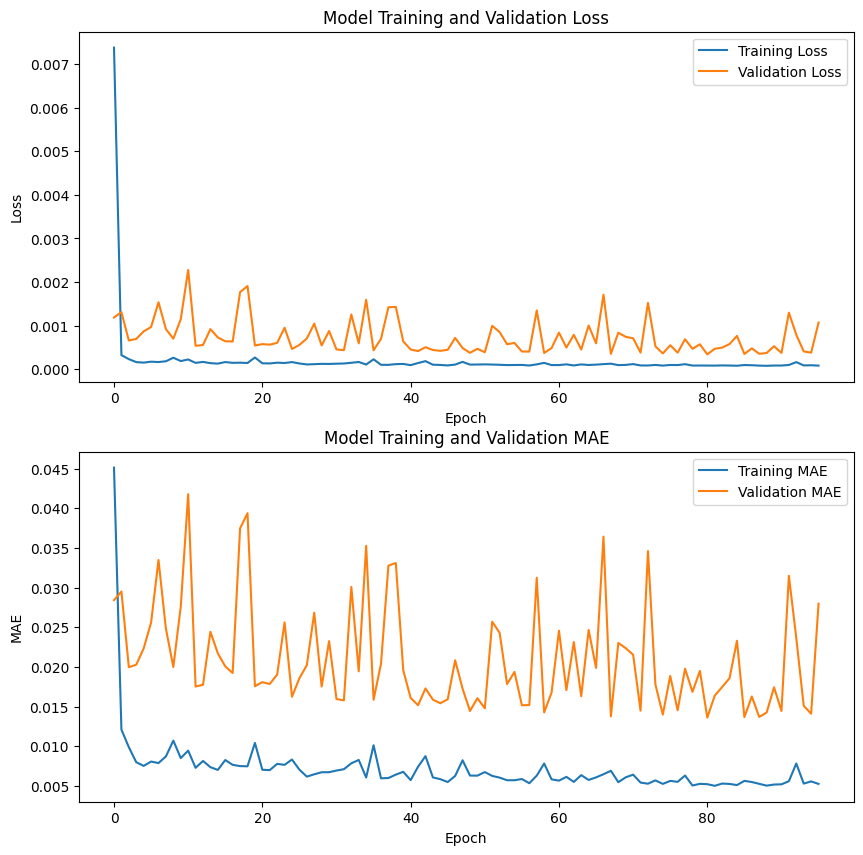

145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step

Predicting 2 days into the future:
Validation Set Metrics:


,0
Model,GRU
Day 1 MSE,4.955843
Day 1 RMSE,2.226172
Day 1 MAE,1.675389
Day 1 R2,0.979665
Day 2 MSE,9.639077
Day 2 RMSE,3.104686
Day 2 MAE,2.326858
Day 2 R2,0.960079


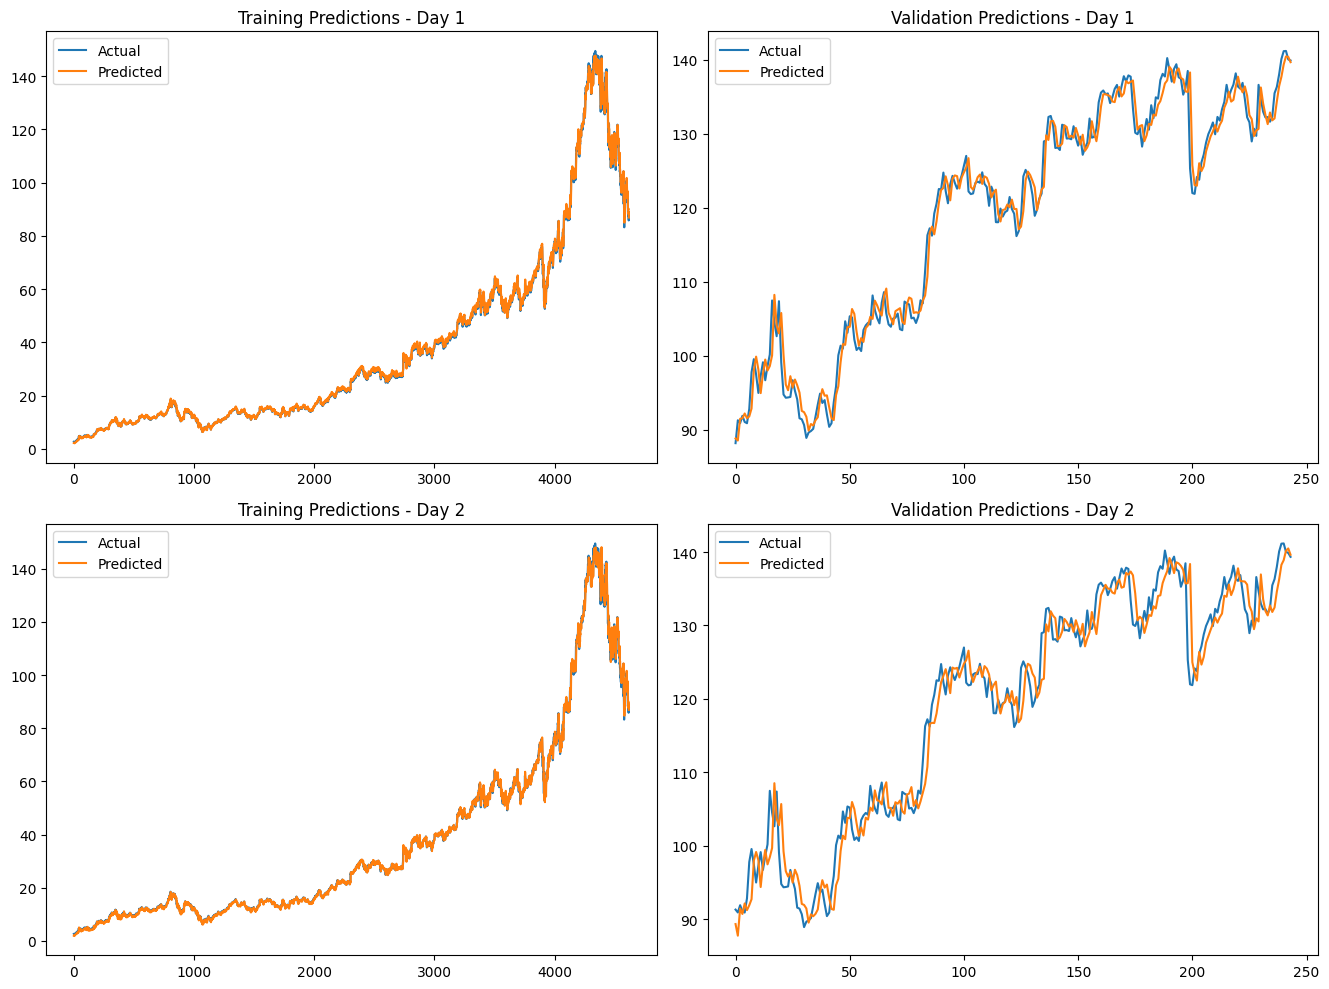

In [23]:
# Plot training history
look_back = best_config_final['look_back']
predict_days = 2

# Prepare data with a single scaler fitted on training data
# Fit scaler only on training data
_, _, feature_scaler, target_scaler = prepare_data(train_data, look_back, predict_days)

# Prepare data using the same scaler
X_train, y_train, _, _ = prepare_data(train_data, look_back, predict_days, feature_scaler, target_scaler)
X_val, y_val, _, _ = prepare_data(val_data, look_back, predict_days, feature_scaler, target_scaler)
X_test, y_test, _, _ = prepare_data(test_data, look_back, predict_days, feature_scaler, target_scaler)

plt.figure(figsize=(10,10))

plt.subplot(2, 1, 1)
plt.plot(best_history_final.history['loss'], label='Training Loss')
plt.plot(best_history_final.history['val_loss'], label='Validation Loss')
plt.title('Model Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(best_history_final.history['mae'], label='Training MAE')
plt.plot(best_history_final.history['val_mae'], label='Validation MAE')
plt.title('Model Training and Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.show()

# Make predictions
train_pred = best_model_final.predict(X_train)
val_pred = best_model_final.predict(X_val)

# Inverse transform predictions
train_pred = target_scaler.inverse_transform(train_pred.reshape(-1, 1)).reshape(-1, predict_days)
y_train_inv = target_scaler.inverse_transform(y_train.reshape(-1, 1)).reshape(-1, predict_days)

val_pred = target_scaler.inverse_transform(val_pred.reshape(-1, 1)).reshape(-1, predict_days)
y_val_inv = target_scaler.inverse_transform(y_val.reshape(-1, 1)).reshape(-1, predict_days)

# Evaluate model for each day of prediction
print(f"\nPredicting {predict_days} days into the future:")

# Validation set metrics
print("Validation Set Metrics:")
df_eval = pd.DataFrame()
df_eval['Model'] = ['GRU']
for day in range(predict_days):
    df_eval[f"Day {day+1} MSE"] = mean_squared_error(y_val_inv[:, day], val_pred[:, day])
    df_eval[f"Day {day+1} RMSE"] = np.sqrt(mean_squared_error(y_val_inv[:, day], val_pred[:, day]))
    df_eval[f"Day {day+1} MAE"] = mean_absolute_error(y_val_inv[:, day], val_pred[:, day])
    df_eval[f"Day {day+1} R2"] = r2_score(y_val_inv[:, day], val_pred[:, day])

display(df_eval.T)

# Visualize predictions
plt.figure(figsize=(20, 5 * predict_days))

# Create subplot for each day's prediction
for day in range(predict_days):
    plt.subplot(predict_days, 3, day*3 + 1)
    plt.title(f'Training Predictions - Day {day+1}')
    plt.plot(y_train_inv[:, day], label='Actual')
    plt.plot(train_pred[:, day], label='Predicted')
    plt.legend()

    plt.subplot(predict_days, 3, day*3 + 2)
    plt.title(f'Validation Predictions - Day {day+1}')
    plt.plot(y_val_inv[:, day], label='Actual')
    plt.plot(val_pred[:, day], label='Predicted')
    plt.legend()

plt.tight_layout()
plt.show()

# 7. Model Evaluation and Prediction

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

Predicting 2 days into the future:
Validation Set Metrics:


,Model,Day 1 MSE,Day 1 RMSE,Day 1 MAE,Day 1 R2,Day 2 MSE,Day 2 RMSE,Day 2 MAE,Day 2 R2
0,GRU,19.990375,4.47106,3.662636,0.894254,25.557826,5.055475,4.171167,0.863803


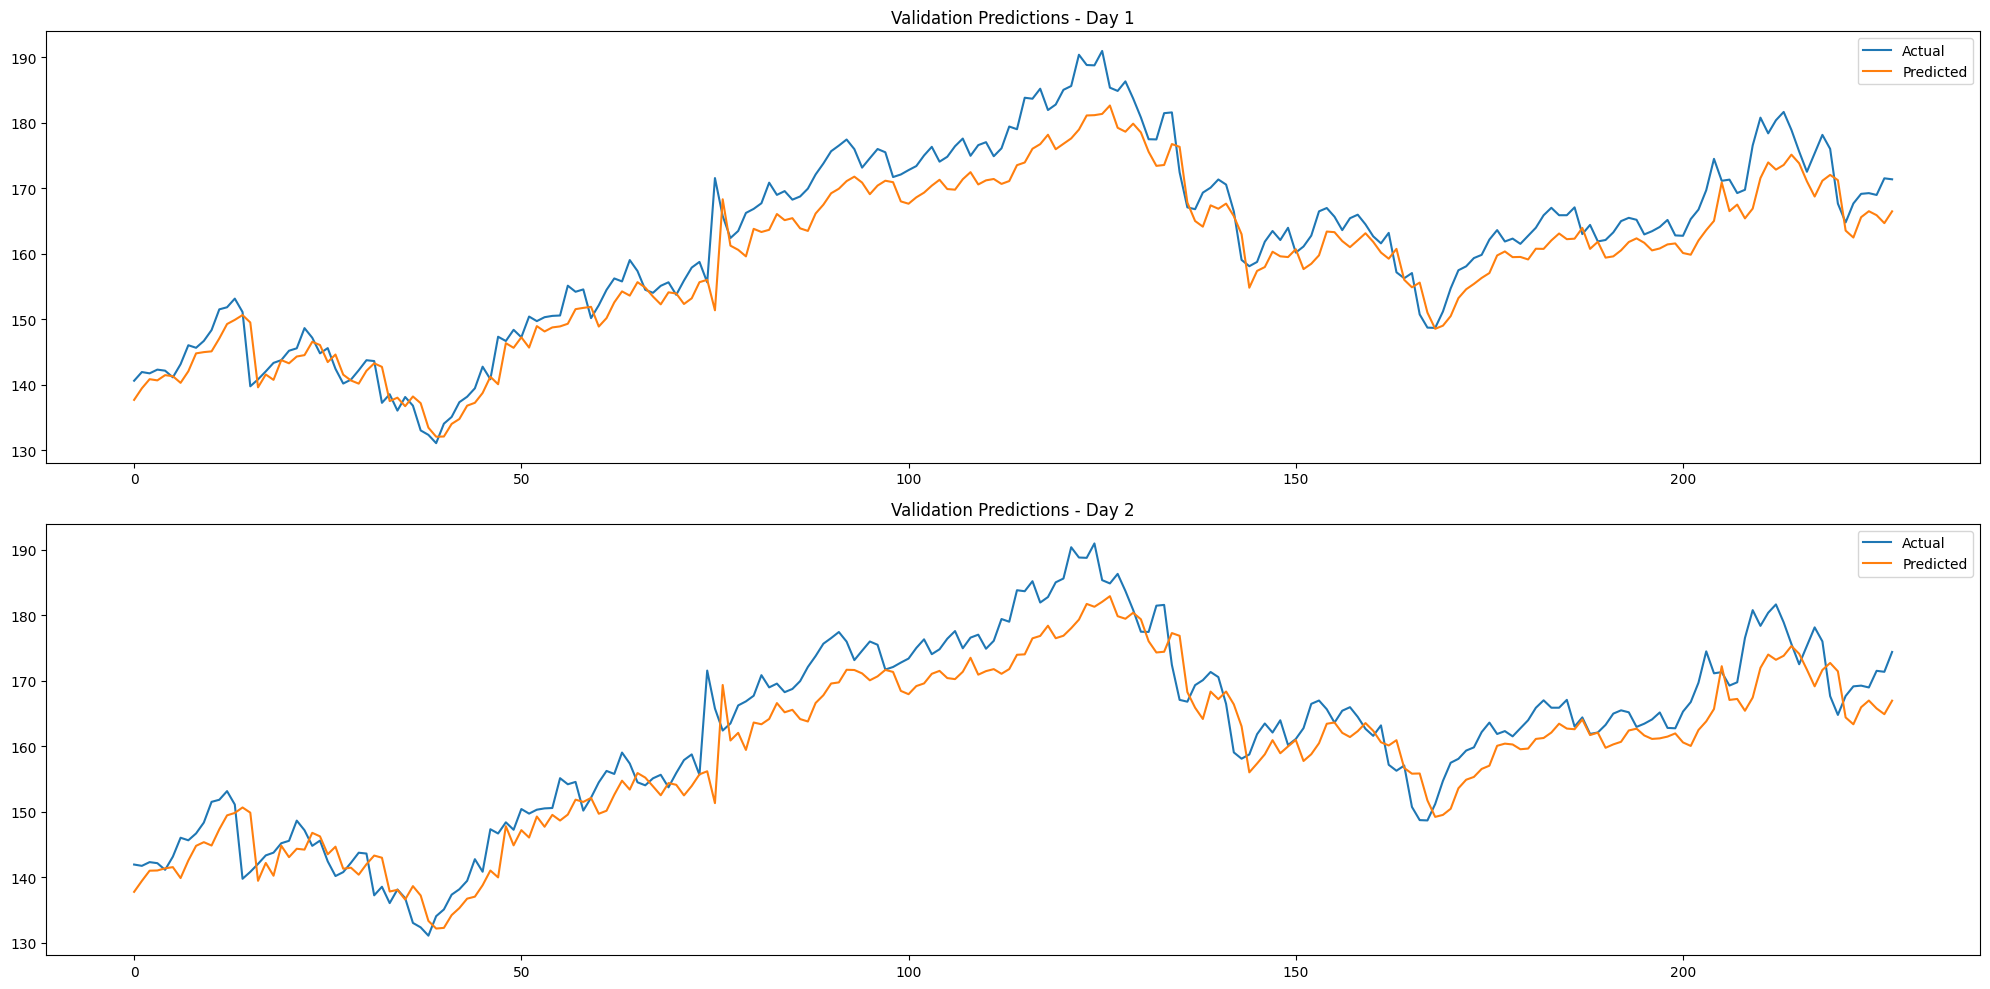

In [25]:
# Make predictions
test_pred = best_model_final.predict(X_test)

test_pred = target_scaler.inverse_transform(test_pred.reshape(-1, 1)).reshape(-1, predict_days)
y_test_inv = target_scaler.inverse_transform(y_test.reshape(-1, 1)).reshape(-1, predict_days)

# Evaluate model for each day of prediction
print(f"\nPredicting {predict_days} days into the future:")

# Validation set metrics
print("Validation Set Metrics:")
df_eval = pd.DataFrame()
df_eval['Model'] = ["GRU"]
for day in range(predict_days):
    df_eval[f"Day {day+1} MSE"] = mean_squared_error(y_test_inv[:, day], test_pred[:, day])
    df_eval[f"Day {day+1} RMSE"] = np.sqrt(mean_squared_error(y_test_inv[:, day], test_pred[:, day]))
    df_eval[f"Day {day+1} MAE"] = mean_absolute_error(y_test_inv[:, day], test_pred[:, day])
    df_eval[f"Day {day+1} R2"] = r2_score(y_test_inv[:, day], test_pred[:, day])

display(df_eval)

# Visualize predictions
plt.figure(figsize=(20, 5 * predict_days))

# Create subplot for each day's prediction
for day in range(predict_days):
    plt.subplot(predict_days, 1, day + 1)
    plt.title(f'Validation Predictions - Day {day+1}')
    plt.plot(y_test_inv[:, day], label='Actual')
    plt.plot(test_pred[:, day], label='Predicted')
    plt.legend()

plt.tight_layout()
plt.show()